In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import image.loadImage as loadImage
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors
from scipy import stats
import matplotlib.image as mpimg
from PIL import Image  
Image.MAX_IMAGE_PIXELS = None
# import cv2
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
from scipy.stats import linregress
from sklearn.neighbors import NearestNeighbors

import anndata as ad
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import gc

In [3]:
name='allk20XA_02_dca_over'
plotsavepath='/mnt/external_ssd/xinyi/plots/train_gae_starmap/'+name+'/newold'

In [4]:
cropsize=200
minmaxsize=400
plotclusters=['0','3','2']
stats3d={}
plot_samples={'disease13':'13months_disease-ADmouse_11346','control13':'13months_control-ADmouse_11351','disease8':'8months_disease-ADmouse_9723_2','control8':'8months_control-ADmouse_9707'}
for s in plot_samples.keys():
    with open('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/stats/'+s+'/'+'stats','rb') as outputseg:
        stats3d[s]=pickle.load(outputseg)

In [5]:
imgInputnp=None
imgInputnp_mean=None
testplaquedistr=None
allCoordnp=None
allimgnp=None
allimgnp_mean=None
dapiIdx=None
# import gc
# gc.collect()

In [6]:
stats3d['disease8'].shape

(8202, 35)

In [7]:
from skimage import io
import cupy as cp
import pyclesperanto_prototype as cle
cle.select_device('cuda')

<TITAN RTX on Platform: NVIDIA CUDA (1 refs)>

In [8]:
gaeClusterPath='/mnt/external_ssd/xinyi/plots/train_gae_starmap/allk20XA_02_dca_over/newold/combinedlogminmax_beforeAct/cluster/leiden_nn10mdist025n_pcs40res0.082epoch9990'
with open(gaeClusterPath, 'rb') as input:
    gaeclusterlabels = pickle.load(input)
    
#crop full image into patches with centered on each cell
datadir='/mnt/external_ssd/xinyi/starmap_new/2022-06-14-Xinyi-mAD'
plot_samples_all={'disease13old':'ADmouse_9494','control13old':'ADmouse_9498','disease8old':'ADmouse_9723','control8old':'ADmouse_9735','disease13':'ADmouse_11346','control13':'ADmouse_11351','disease8':'ADmouse_9723_2','control8':'ADmouse_9707'}
plot_samples_old={'disease13old':'AD_mouse9494','control13old':'AD_mouse9498','disease8old':'AD_mouse9723','control8old':'AD_mouse9735'}

olddata=scanpy.read_h5ad('/home/xinyiz/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
oldgenes=olddata.var.index.to_numpy()

gaeCoord=None
sampleNames=None
celltype_broad=None
celltype_sub=None
scaleddata=scanpy.read_h5ad(datadir+'/2022-04-06-Hu-AD-stardist-scaled.h5ad')
for s in plot_samples_all.keys():
    if 'old' in s:
        sampleidx_s=plot_samples_old[s]
    else:
        sampleidx_s=plot_samples_all[s] 
    if gaeCoord is None:
        if 'old' in s:
            gaeCoord=olddata.obs.loc[olddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()
            sampleNames=np.repeat(s,np.sum(olddata.obs['sample']==sampleidx_s))
            celltype_broad=olddata.obs.loc[olddata.obs['sample']==sampleidx_s,['top_level']].to_numpy()
            celltype_sub=olddata.obs.loc[olddata.obs['sample']==sampleidx_s,['cell_type_label']].to_numpy()
        else:
            gaeCoord=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()
            sampleNames=np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))
            celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['top_level']].to_numpy()
            celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['cell_type']].to_numpy()
    else:
        if 'old' in s:
            gaeCoord=np.concatenate((gaeCoord,olddata.obs.loc[olddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()),axis=0)
            sampleNames=np.concatenate((sampleNames,np.repeat(s,np.sum(olddata.obs['sample']==sampleidx_s))),axis=None)
            celltype_broad=np.concatenate((celltype_broad,olddata.obs.loc[olddata.obs['sample']==sampleidx_s,['top_level']].to_numpy()))
            celltype_sub=np.concatenate((celltype_sub,olddata.obs.loc[olddata.obs['sample']==sampleidx_s,['cell_type_label']].to_numpy()))
        else:
            gaeCoord=np.concatenate((gaeCoord,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()),axis=0)
            sampleNames=np.concatenate((sampleNames,np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))),axis=None)
            celltype_broad=np.concatenate((celltype_broad,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['top_level']].to_numpy()))
            celltype_sub=np.concatenate((celltype_sub,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['cell_type']].to_numpy()))
celltype_broad=celltype_broad.flatten()


In [10]:
#calculate mean and std for each cell type 
voxel_size_x = 0.0946
voxel_size_y = 0.0946
voxel_size_z = 0.3463

ctPixelIntensity={}
pixelRange={}
for s in plot_samples.keys():
    print(s)
    img=io.imread('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/'+plot_samples[s]+'.tif')
    ctPixelIntensity[s]={}
    pixelRange[s]={}
    for ct in np.unique(celltype_broad[sampleNames==s]):
        ctPixelIntensity[s][ct]={}
        pixelRange[s][ct]={}
        for c in plotclusters:
            ctPixelIntensity[s][ct][c]=np.array([])
            pixelRange[s][ct][c]=np.array([])
    
    cellidx=np.arange(np.sum(sampleNames==s))
    
    for c in plotclusters:
        print(c)
        
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        print(np.sum(cidx))
        if np.sum(cidx)==0:
            continue
        
    
        coordNp=gaeCoord[sampleNames==s][cidx]
        allCTnp=celltype_broad[sampleNames==s][cidx]
        cellidxSC=cellidx[cidx]
        
        
        for i in range(coordNp.shape[0]):
            centroid=coordNp[i]


            radius=minmaxsize
            rowstart=int(max(0,centroid[0]-radius))
            rowend=int(min(img.shape[1],centroid[0]+radius))
            colstart=int(max(0,centroid[1]-radius))
            colend=int(min(img.shape[2],centroid[1]+radius))

            if centroid[0]-minmaxsize<0:
                centroidx=centroid[0]
            else:
                centroidx=minmaxsize
            if centroid[1]-minmaxsize<0:
                centroidy=centroid[1]
            else:
                centroidy=minmaxsize
            
            with open('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/stats/'+s+'/'+str(cellidxSC[i]),'rb') as outputseg:
                dapiIdx=pickle.load(outputseg)
            dapiIdx=dapiIdx.get()
#             testinput=img[:,rowstart:rowend,colstart:colend]
#             testinput=(testinput-np.min(testinput))/(np.max(testinput)-np.min(testinput))
#             testinput=testinput[:,max(0,centroidx-cropsize):min(testinput.shape[1],centroidx+cropsize),max(0,centroidy-cropsize):min(testinput.shape[2],centroidy+cropsize)]
#             input_gpu = cle.push(testinput)
#             resampled = cle.create([int(input_gpu.shape[0]*voxel_size_z/voxel_size_x), input_gpu.shape[1],input_gpu.shape[2] ])
#             cle.scale(input_gpu, resampled, factor_x=1, factor_y=1, factor_z=voxel_size_z/voxel_size_x, centered=False)
#             testinput=np.array(resampled)[dapiIdx]
        
#             ctPixelIntensity[s][allCTnp[i]][c]=np.concatenate((ctPixelIntensity[s][allCTnp[i]][c],testinput.flatten()))
            pixelRange[s][allCTnp[i]][c]=np.concatenate((pixelRange[s][allCTnp[i]][c],[np.sum(dapiIdx)]))
    img=None
    gc.collect()


disease13
0
1408
3
513
2
1335
control13
0
1718
3
917
2
1081
disease8
0
1084
3
1796
2
967
control8
0
2223
3
1032
2
1210


In [11]:
img.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [10]:
with open(os.path.join(plotsavepath,'ctPixelIntensity'),'wb') as output:
    pickle.dump(ctPixelIntensity,output)

In [11]:
with open(os.path.join(plotsavepath,'pixelRange'),'wb') as output:
    pickle.dump(pixelRange,output)

In [12]:
with open(os.path.join(plotsavepath,'ctPixelIntensity'),'rb') as output:
    ctPixelIntensity=pickle.load(output)

In [14]:
with open(os.path.join(plotsavepath,'pixelRange'),'rb') as output:
    pixelRange=pickle.load(output)

In [22]:
stdthresh=1.5
if not os.path.exists(os.path.join(plotsavepath,'pixelIntensity')):
    os.mkdir(os.path.join(plotsavepath,'pixelIntensity'))
ctPixelIntensity_sum={}
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
    print(s)
    ctPixelIntensity_sum[s]={}
    for ct in ctPixelIntensity[s]:
        allpixels=np.array([])
        for c in ctPixelIntensity[s][ct].keys():
            plt.hist(ctPixelIntensity[s][ct][c],bins=40)
            plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+c+s+'.jpg'),dpi=300)
            plt.close()
            allpixels=np.concatenate((allpixels,ctPixelIntensity[s][ct][c]))
        if allpixels.size==0:
            continue
        ctPixelIntensity_sum[s][ct]=[np.mean(allpixels),np.std(allpixels)]
        plt.hist(allpixels,bins=40)
        plt.axvline(x=ctPixelIntensity_sum[s][ct][0]+stdthresh*ctPixelIntensity_sum[s][ct][1],color='red')
        plt.axvline(x=ctPixelIntensity_sum[s][ct][0]-stdthresh*ctPixelIntensity_sum[s][ct][1],color='red')
        plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+s+'.jpg'),dpi=300)
        plt.close()
        
        
        

disease13
control13
disease8
control8


In [23]:
#add column in res
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
    for c in plotclusters:
        res[s][c]=np.hstack((res[s][c],np.zeros(res[s][c].shape[0]).reshape((-1,1))))

In [24]:
#separate HC EC pixels
for s in plot_samples.keys():
    print(s)
#     img=io.imread('/mnt/external_ssd/xinyi/2021-07-12-mAD-2766-genes-original-images/ADmouse_'+plot_samples[s][-4:]+'/pi.tif')
    cellidx=np.arange(np.sum(sampleNames==s))
    
    for c in plotclusters:
        print(c)
        
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        print(np.sum(cidx))
        if np.sum(cidx)==0:
            continue
        
    
        coordNp=gaeCoord[sampleNames==s][cidx]
        allCTnp=celltype_broad[sampleNames==s][cidx]
        cellidxSC=cellidx[cidx]
        
        previdx={}
        ctcount={}
        for ct in np.unique(allCTnp):
            ctcount[ct]=0
            previdx[ct]=0
        for i in range(coordNp.shape[0]):
            isize=pixelRange[s][allCTnp[i]][c][ctcount[allCTnp[i]]]
            ctcount[allCTnp[i]]+=1
            testinput=ctPixelIntensity[s][allCTnp[i]][c][int(previdx[allCTnp[i]]):int(previdx[allCTnp[i]]+isize)]
            nhc=np.sum(testinput>ctPixelIntensity_sum[s][allCTnp[i]][0]+stdthresh*ctPixelIntensity_sum[s][allCTnp[i]][1])
            nec=np.sum(testinput<ctPixelIntensity_sum[s][allCTnp[i]][0]-stdthresh*ctPixelIntensity_sum[s][allCTnp[i]][1])
            if nhc+nec!=0:
                res[s][c][i,11]=nhc/(nhc+nec)
            previdx[allCTnp[i]]+=isize
#     img=None
#     gc.collect()


disease13
0
1226
1
1167
3
1141
control13
0
1309
1
1136
3
838
disease8
0
1311
1
1582
3
1096
control8
0
1585
1
648
3
1390


In [14]:
#mean lower threshold for HC - use controls separately for diff. time points; combine all three clusters
#pixel intensity variance
ctmeanlowerHCthresh={}
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
    print(s)
    ctmeanlowerHCthresh[s]={}
    normfactor={}
    cellidx=np.arange(np.sum(sampleNames==s))
    
    for ct in np.unique(celltype_broad):
        ctmeanlowerHCthresh[s][ct]=0
        normfactor[ct]=0
    for c in plotclusters:
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        
        print(np.sum(cidx))
        if np.sum(cidx)==0:
            continue
        

        allCTnp=celltype_broad[sampleNames==s][cidx]
        cellidxSC=cellidx[cidx]

        previdx={}
        ctcount={}
        for ct in np.unique(allCTnp):
            ctcount[ct]=0
            previdx[ct]=0
            normfactor[ct]+=np.sum(allCTnp==ct)
        for i in range(allCTnp.shape[0]):
            currct=allCTnp[i]
            isize=pixelRange[s][currct][c][ctcount[currct]]
            ctcount[currct]+=1
            testinput=ctPixelIntensity[s][currct][c][int(previdx[currct]):int(previdx[currct]+isize)]
            ctmeanlowerHCthresh[s][currct]+=(0.75*np.max(testinput)+0.65*np.min(testinput))/2
            previdx[currct]+=isize
    for ct in np.unique(allCTnp):
        ctmeanlowerHCthresh[s][ct]=ctmeanlowerHCthresh[s][ct]/normfactor[ct]



disease13
0
1408
3
513
2
1335
control13
0
1718
3
917
2
1081
disease8
0
1084
3
1796
2
967
control8
0
2223
3
1032
2
1210


In [22]:
np.unique([i for i in ctPixelIntensity['disease13'].keys()])

array(['Astro', 'CA1', 'CA2', 'CA3', 'CTX-Ex', 'DG', 'Endo', 'Inh', 'LHb',
       'Micro', 'OPC', 'Oligo', 'SMC'], dtype='<U6')

In [16]:
for s in plot_samples.keys():
#     if 'control' in s:
#         continue
    if '13' in s:
        sthresh='control13'
    if '8' in s:
        sthresh='control8'
    for ct in ctPixelIntensity[s].keys():
        allpixels=np.array([])
        for c in ctPixelIntensity[s][ct].keys():
            plt.hist(ctPixelIntensity[s][ct][c],bins=40)
            plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
            plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+c+s+'_lowerhcthresh.jpg'),dpi=300)
            plt.close()
            allpixels=np.concatenate((allpixels,ctPixelIntensity[s][ct][c]))
        if allpixels.size==0:
            continue
        plt.hist(allpixels,bins=40)
        plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
        plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+s+'_lowerhcthresh.jpg'),dpi=300)
        plt.close()

In [23]:
for s in ['13','8']:
#     if 'control' in s:
#         continue
    if '13' in s:
        sthresh='control13'
    if '8' in s:
        sthresh='control8'
    for ct in ctPixelIntensity['control'+s].keys():
#         if ct == 'Ex':
#             continue
#         allpixels_control=np.array([])
#         allpixels_disease=np.array([])
        for c in ctPixelIntensity['control'+s][ct].keys():
            plt.hist(ctPixelIntensity['control'+s][ct][c],bins=40,color='orange',alpha=0.5)
            plt.hist(ctPixelIntensity['disease'+s][ct][c],bins=40,color='blue',alpha=0.5)
            plt.legend(['control','TauPS2APP'])
            plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
            plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+c+s+'_lowerhcthresh.jpg'),dpi=300)
            plt.close()
# #             allpixels_control=np.concatenate((allpixels_control,ctPixelIntensity['control'+s][ct][c]))
# #             allpixels_disease=np.concatenate((allpixels_disease,ctPixelIntensity['disease'+s][ct][c]))
# #         if allpixels_control.size+allpixels_disease.size==0:
# #             continue
#         plt.hist(np.concatenate((ctPixelIntensity['control'+s][ct]['0'],np.concatenate((ctPixelIntensity['control'+s][ct]['1'],ctPixelIntensity['control'+s][ct]['3'])))),bins=40,color='orange',alpha=0.5)
#         plt.hist(np.concatenate((ctPixelIntensity['disease'+s][ct]['0'],np.concatenate((ctPixelIntensity['disease'+s][ct]['1'],ctPixelIntensity['disease'+s][ct]['3'])))),bins=40,color='blue',alpha=0.5)
#         plt.legend(['control','TauPS2APP'])
#         plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
#         plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+s+'_lowerhcthresh.jpg'),dpi=300)
#         plt.close()

In [50]:
d=None
gc.collect()

61149

In [34]:
maxPix={'Micro':0.15,'Oligo':0.13,'CTX-Ex':0.2}

In [35]:
for s in ['13','8']:
#     if 'control' in s:
#         continue
    if '13' in s:
        sthresh='control13'
    if '8' in s:
        sthresh='control8'
#     for ct in ctPixelIntensity['control'+s].keys():
    for ct in maxPix.keys():
#         if ct != 'Oligo':
#             continue
        allpixels_control=np.array([])
        allpixels_disease=np.array([])
        n1sum=0
        n2sum=0
        for c in ctPixelIntensity['control'+s][ct].keys():
#             n1=np.sum(np.logical_and((gaeclusterlabels==c)[sampleNames==('control'+s)],np.logical_and(np.sum(stats3d['control'+s],axis=1)>0,(celltype_broad==ct)[sampleNames==('control'+s)])))
#             n2=np.sum(np.logical_and((gaeclusterlabels==c)[sampleNames==('disease'+s)],np.logical_and(np.sum(stats3d['disease'+s],axis=1)>0,(celltype_broad==ct)[sampleNames==('disease'+s)])))
            n1=ctPixelIntensity['control'+s][ct][c].size
            n2=ctPixelIntensity['disease'+s][ct][c].size
            n1sum+=n1
            n2sum+=n2
#             plt.hist(ctPixelIntensity['disease'+s][ct][c],bins=40,weights=np.repeat(1/n2,(ctPixelIntensity['disease'+s][ct][c]).size),color='blue',alpha=0.5, label='AD')
            plt.hist(ctPixelIntensity['control'+s][ct][c],bins=40,weights=np.repeat(1/n1,(ctPixelIntensity['control'+s][ct][c]).size),color='orange',alpha=0.5, label='Control')
            plt.hist(ctPixelIntensity['disease'+s][ct][c],bins=40,weights=np.repeat(1/n2,(ctPixelIntensity['disease'+s][ct][c]).size),color='blue',alpha=0.5, label='AD')
            plt.ylim(0,maxPix[ct])
            plt.legend()
            plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
            plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+c+s+'_lowerhcthresh_norm.jpg'),dpi=300)
            plt.close()
#             allpixels_control=np.concatenate((allpixels_control,ctPixelIntensity['control'+s][ct][c]))
#             allpixels_disease=np.concatenate((allpixels_disease,ctPixelIntensity['disease'+s][ct][c]))
#         if allpixels_control.size+allpixels_disease.size==0:
#             continue
#         if ct != 'Ex':
#             continue
#         if ct !='Micro':
#             continue
        n1=n1sum
        n2=n2sum
        d=np.concatenate((ctPixelIntensity['control'+s][ct]['0'],np.concatenate((ctPixelIntensity['control'+s][ct]['3'],ctPixelIntensity['control'+s][ct]['2']))))
        plt.hist(d,bins=40,weights=np.repeat(1/n1,d.size),color='orange',alpha=0.5, label='Control')
#         d=np.concatenate((ctPixelIntensity['disease'+s][ct]['0'],np.concatenate((ctPixelIntensity['disease'+s][ct]['3'],ctPixelIntensity['disease'+s][ct]['2']))))
#         plt.hist(d,bins=40,weights=np.repeat(1/n2,d.size),color='blue',alpha=0.5, label='AD')
        d=None
        d=np.concatenate((ctPixelIntensity['disease'+s][ct]['0'],np.concatenate((ctPixelIntensity['disease'+s][ct]['3'],ctPixelIntensity['disease'+s][ct]['2']))))
        plt.hist(d,bins=40,weights=np.repeat(1/n2,d.size),color='blue',alpha=0.5, label='AD')
#         d=np.concatenate((ctPixelIntensity['control'+s][ct]['0'],np.concatenate((ctPixelIntensity['control'+s][ct]['3'],ctPixelIntensity['control'+s][ct]['2']))))
#         plt.hist(d,bins=40,weights=np.repeat(1/n1,d.size),color='orange',alpha=1, label='control')

        plt.legend()
        plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
        plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+s+'_lowerhcthresh_norm.jpg'),dpi=300)
        plt.close()

In [52]:
for s in ['control','disease']:
#     if 'control' in s:
#         continue
#     if '13' in s:
#         sthresh='control13'
#     if '8' in s:
#         sthresh='control8'
    for ct in ctPixelIntensity[s+'8'].keys():
#         if ct == 'Ex':
#             continue
#         allpixels_control=np.array([])
#         allpixels_disease=np.array([])
        for c in ctPixelIntensity[s+'8'][ct].keys():
            plt.hist(ctPixelIntensity[s+'8'][ct][c],bins=40,color='orange',alpha=0.5)
            plt.hist(ctPixelIntensity[s+'13'][ct][c],bins=40,color='blue',alpha=0.5)
            plt.legend(['8 months','13 months'])
#             plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
            plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+c+s+'_lowerhcthresh.jpg'),dpi=300)
            plt.close()
#             allpixels_control=np.concatenate((allpixels_control,ctPixelIntensity['control'+s][ct][c]))
#             allpixels_disease=np.concatenate((allpixels_disease,ctPixelIntensity['disease'+s][ct][c]))
#         if allpixels_control.size+allpixels_disease.size==0:
#             continue
        plt.hist(np.concatenate((ctPixelIntensity[s+'8'][ct]['0'],np.concatenate((ctPixelIntensity[s+'8'][ct]['1'],ctPixelIntensity[s+'8'][ct]['3'])))),bins=40,color='orange',alpha=0.5)
        plt.hist(np.concatenate((ctPixelIntensity[s+'13'][ct]['0'],np.concatenate((ctPixelIntensity[s+'13'][ct]['1'],ctPixelIntensity[s+'13'][ct]['3'])))),bins=40,color='blue',alpha=0.5)
        plt.legend(['8 months','13 months'])
#         plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
        plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+s+'_lowerhcthresh.jpg'),dpi=300)
        plt.close()

In [44]:
for s in ['control','disease']:
#     if 'control' in s:
#         continue
#     if '13' in s:
#         sthresh='control13'
#     if '8' in s:
#         sthresh='control8'
#     for ct in ctPixelIntensity[s+'8'].keys():
    for ct in maxPix.keys():
#         if ct == 'Ex':
#             continue
#         allpixels_control=np.array([])
#         allpixels_disease=np.array([])
        for c in ctPixelIntensity[s+'8'][ct].keys():
#             n1=np.sum(np.logical_and((gaeclusterlabels==c)[sampleNames==(s+'8')],np.logical_and(np.sum(stats3d[s+'8'],axis=1)>0,(celltype_broad==ct)[sampleNames==(s+'8')])))
#             n2=np.sum(np.logical_and((gaeclusterlabels==c)[sampleNames==(s+'13')],np.logical_and(np.sum(stats3d[s+'13'],axis=1)>0,(celltype_broad==ct)[sampleNames==(s+'13')])))
            n1=ctPixelIntensity[s+'8'][ct][c].size
            n2=ctPixelIntensity[s+'13'][ct][c].size
            plt.hist(ctPixelIntensity[s+'8'][ct][c],bins=40,weights=np.repeat(1/n1,(ctPixelIntensity[s+'8'][ct][c]).size),color='orange',alpha=0.5)
            plt.hist(ctPixelIntensity[s+'13'][ct][c],bins=40,weights=np.repeat(1/n2,(ctPixelIntensity[s+'13'][ct][c]).size),color='blue',alpha=0.5)
            plt.ylim(0,maxPix[ct])
            plt.legend(['8 months','13 months'])
#             plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
            plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+c+s+'_lowerhcthresh.jpg'),dpi=300)
            plt.close()
# #             allpixels_control=np.concatenate((allpixels_control,ctPixelIntensity[s+'8'][ct][c]))
# #             allpixels_disease=np.concatenate((allpixels_disease,ctPixelIntensity[s+'13'][ct][c]))
# #         if allpixels_control.size+allpixels_disease.size==0:
# #             continue
#         n1=np.sum(np.logical_and(sampleNames==(s+'8'),np.logical_or(gaeclusterlabels=='0',np.logical_or(gaeclusterlabels=='1',gaeclusterlabels=='3'))))
#         n2=np.sum(np.logical_and(sampleNames==(s+'13'),np.logical_or(gaeclusterlabels=='0',np.logical_or(gaeclusterlabels=='1',gaeclusterlabels=='3'))))
#         d=np.concatenate((ctPixelIntensity[s+'8'][ct]['0'],np.concatenate((ctPixelIntensity[s+'8'][ct]['1'],ctPixelIntensity[s+'8'][ct]['3']))))
#         plt.hist(d,bins=40,weights=np.repeat(1/n1,d.size),color='orange',alpha=0.5)
#         d=None
#         d=np.concatenate((ctPixelIntensity[s+'13'][ct]['0'],np.concatenate((ctPixelIntensity[s+'13'][ct]['1'],ctPixelIntensity[s+'13'][ct]['3']))))
#         plt.hist(d,bins=40,weights=np.repeat(1/n2,d.size),color='blue',alpha=0.5)
#         plt.legend(['8 months','13 months'])
# #         plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
#         plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+s+'_lowerhcthresh_norm.jpg'),dpi=300)
#         plt.close()
        

In [43]:
s='disease8'
c='3'
cidx=gaeclusterlabels[sampleNames==s]==c
cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
allCTnp=celltype_broad[sampleNames==s][cidx]
np.sum(allCTnp=='Micro')

131

In [45]:
#plot pixel intensity distributions in some cells
np.random.seed(3)
nexamples=20
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
    print(s)
    if '13' in s:
        sthresh='control13'
    if '8' in s:
        sthresh='control8'
    cellidx=np.arange(np.sum(sampleNames==s))
    
    for c in plotclusters:
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        
        print(np.sum(cidx))
        if np.sum(cidx)==0:
            continue
        
        examplesavepath=os.path.join(plotsavepath,'pixelIntensity',s+c+'_examples')
        if not os.path.exists(examplesavepath):
            os.mkdir(examplesavepath)
        allCTnp=celltype_broad[sampleNames==s][cidx]
        cellidxSC=cellidx[cidx]

        previdx={}
        ctcount={}
        ctplotidx={}
        for ct in np.unique(allCTnp):
            ctcount[ct]=0
            previdx[ct]=0
            ctplotidx[ct]=np.random.choice(np.arange(np.sum(allCTnp==ct)),size=min(np.sum(allCTnp==ct),nexamples),replace=False)
        for i in range(allCTnp.shape[0]):
            currct=allCTnp[i]
            isize=pixelRange[s][currct][c][ctcount[currct]]
            ctcount[currct]+=1
            testinput=ctPixelIntensity[s][currct][c][int(previdx[currct]):int(previdx[currct]+isize)]
            previdx[currct]+=isize
            
            if ctcount[currct]-1 in ctplotidx[currct]:
                plt.hist(testinput,bins=40,range=(0,1))
                plt.axvline(x=ctmeanlowerHCthresh[sthresh][currct],color='red')
                plt.savefig(os.path.join(examplesavepath,currct+str(ctcount[currct]-1)+'.jpg'),dpi=300)
                plt.close()



disease13
0
1408
3
513
2
1335
control13
0
1718
3
917
2
1081
disease8
0
1084
3
1796
2
967
control8
0
2223
3
1032
2
1210


In [30]:
#add column in res
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
    for c in plotclusters:
        res[s][c]=np.hstack((res[s][c],np.zeros(res[s][c].shape[0]).reshape((-1,1))))

In [31]:
#HC intensity/total intensity

# for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
#     for c in plotclusters:
#         res[s][c][:,-1]=np.zeros(res[s][c].shape[0])
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
#     if 'disease13' == s:
#         continue
    print(s)
    if '13' in s:
        sthresh='control13'
    if '8' in s:
        sthresh='control8'
    cellidx=np.arange(np.sum(sampleNames==s))
    
    for c in plotclusters:
        print(c)
        
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        print(np.sum(cidx))
        if np.sum(cidx)==0:
            continue
        
    
        allCTnp=celltype_broad[sampleNames==s][cidx]
        cellidxSC=cellidx[cidx]
        
        previdx={}
        ctcount={}
        for ct in np.unique(allCTnp):
            ctcount[ct]=0
            previdx[ct]=0
        for i in range(allCTnp.shape[0]):
            isize=pixelRange[s][allCTnp[i]][c][ctcount[allCTnp[i]]]
            ctcount[allCTnp[i]]+=1
            testinput=ctPixelIntensity[s][allCTnp[i]][c][int(previdx[allCTnp[i]]):int(previdx[allCTnp[i]]+isize)]
            res[s][c][i,14]=np.sum(testinput[testinput>ctmeanlowerHCthresh[sthresh][allCTnp[i]]])/np.sum(testinput)
            previdx[allCTnp[i]]+=isize


disease13
0
1226
1
1167
3
1141
control13
0
1309
1
1136
3
838
disease8
0
1311
1
1582
3
1096
control8
0
1585
1
648
3
1390


In [32]:
with open(os.path.join(plotsavepath,'res_wcontrols'),'wb') as output:
    pickle.dump(res,output)

In [10]:
with open(os.path.join(plotsavepath,'res_wcontrols'),'rb') as input:
    res=pickle.load(input)

In [11]:
import seaborn as sns


In [12]:
for s in plot_samples.keys():
#     if 'control' in s:
#         continue
    for c in plotclusters:
        res[s][c]=np.array(res[s][c])

In [13]:
maxvalues={}
for c in plotclusters:
    if c=='8':
        continue
    maxvalues[c]=np.max(np.vstack((np.max(res['disease13'][c],axis=0),np.max(res['disease8'][c],axis=0))),axis=0)

In [14]:
minvalues={}
for c in plotclusters:
    if c=='8':
        continue
    minvalues[c]=np.min(np.vstack((np.min(res['disease13'][c],axis=0),np.min(res['disease8'][c],axis=0))),axis=0)

In [15]:
import scipy.stats

In [21]:
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='disease8']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['disease8'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease13']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease13'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='disease8'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease13'][cidx8]
        ex8=np.array(res['disease8'][c][:,0]).flatten()[allCTnpd13=='Ex']
        ex13=np.array(res['disease13'][c][:,0]).flatten()[allCTnpd8=='Ex']
        for ct in np.unique(celltype_broad):
            if np.sum(allCTnpd13==ct)!=0 and ct != 'Ex':
                print('8 '+ct)
                print(scipy.stats.ttest_ind(ex8,np.array(res['disease8'][c][:,0]).flatten()[allCTnpd13==ct]))
            if np.sum(allCTnpd8==ct)!=0 and ct != 'Ex':
                print('13 '+ct)
                print(scipy.stats.ttest_ind(ex13,np.array(res['disease13'][c][:,0]).flatten()[allCTnpd8==ct]))
            if np.sum(allCTnpd13==ct)!=0 and np.sum(allCTnpd8==ct)!=0:
                print('8 vs 13 '+ct)
                print(scipy.stats.ttest_ind(np.array(res['disease8'][c][:,0]).flatten()[allCTnpd13==ct],np.array(res['disease13'][c][:,0]).flatten()[allCTnpd8==ct]))

0
8 Astro
Ttest_indResult(statistic=-1.4528462656656311, pvalue=0.14659840376723812)
13 Astro
Ttest_indResult(statistic=-3.5628671893850283, pvalue=0.0003890224004944285)
8 vs 13 Astro
Ttest_indResult(statistic=0.4244239502804732, pvalue=0.6719128392081583)
8 CA1
Ttest_indResult(statistic=-1.5947007413070704, pvalue=0.11113782540979644)
8 CA3
Ttest_indResult(statistic=0.35235110277228154, pvalue=0.7246592386521028)
8 DG
Ttest_indResult(statistic=1.3202307705303429, pvalue=0.18710087833420358)
8 Endo
Ttest_indResult(statistic=-7.634839126367407, pvalue=5.579945630265216e-14)
13 Endo
Ttest_indResult(statistic=-14.143636962671344, pvalue=1.2393306458626687e-40)
8 vs 13 Endo
Ttest_indResult(statistic=-0.8099045156335489, pvalue=0.4194526874379284)
8 vs 13 Ex
Ttest_indResult(statistic=5.891454113829635, pvalue=4.6640154742565565e-09)
8 Inhi
Ttest_indResult(statistic=-0.3812491538559495, pvalue=0.7030984826760078)
13 Inhi
Ttest_indResult(statistic=-4.526772614149418, pvalue=6.861160976222439

/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [23]:
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='control13']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['control13'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease13']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease13'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='control13'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease13'][cidx8]
        ex8=np.array(res['control13'][c][:,0]).flatten()[allCTnpd13=='Ex']
        ex13=np.array(res['disease13'][c][:,0]).flatten()[allCTnpd8=='Ex']
        for ct in np.unique(celltype_broad):
#             if np.sum(allCTnpd13==ct)!=0 and ct != 'Ex':
#                 print('8 '+ct)
#                 print(scipy.stats.ttest_ind(ex8,np.array(res['control13'][c][:,0]).flatten()[allCTnpd13==ct]))
#             if np.sum(allCTnpd8==ct)!=0 and ct != 'Ex':
#                 print('13 '+ct)
#                 print(scipy.stats.ttest_ind(ex13,np.array(res['disease13'][c][:,0]).flatten()[allCTnpd8==ct]))
            if np.sum(allCTnpd13==ct)!=0 and np.sum(allCTnpd8==ct)!=0:
                print('c vs d '+ct)
                print(scipy.stats.ttest_ind(np.array(res['control13'][c][:,14]).flatten()[allCTnpd13==ct],np.array(res['disease13'][c][:,14]).flatten()[allCTnpd8==ct]))

0
c vs d Astro
Ttest_indResult(statistic=-5.29400698303407, pvalue=4.484842243460701e-07)
c vs d Endo
Ttest_indResult(statistic=-6.7155352395096495, pvalue=3.197033120845173e-10)
c vs d Ex
Ttest_indResult(statistic=-4.338690167412643, pvalue=1.5252997175408448e-05)
c vs d Inhi
Ttest_indResult(statistic=-3.4200125607059704, pvalue=0.0007215449971867179)
c vs d Micro
Ttest_indResult(statistic=-5.495216654617201, pvalue=1.899219171418485e-07)
c vs d OPC
Ttest_indResult(statistic=-0.31379781879962776, pvalue=0.7562780290615226)
c vs d Oligo
Ttest_indResult(statistic=-2.306366911673638, pvalue=0.02240627597532898)
c vs d SMC
Ttest_indResult(statistic=-3.2733532768780056, pvalue=0.001716110935715109)
1
c vs d Astro
Ttest_indResult(statistic=-6.048290435967044, pvalue=8.714596409976957e-09)
c vs d DG
Ttest_indResult(statistic=1.892174198194109, pvalue=0.07303540642260159)
c vs d Endo
Ttest_indResult(statistic=-5.82168168800231, pvalue=2.7047771773138218e-08)
c vs d Ex
Ttest_indResult(statisti

In [84]:
#violin plots of avg grad, disease samples & cell types/cluster -- disease
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='disease8']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['disease8'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease13']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease13'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='disease8'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease13'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'average gradient':np.concatenate((np.array(res['disease8'][c][:,0]).flatten(),np.array(res['disease13'][c][:,0]).flatten())),
                                         'sample':np.concatenate((np.repeat('disease8',res['disease8'][c].shape[0]),np.repeat('disease13',res['disease13'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        sns.set(font_scale = 1.1)
        ax = sns.violinplot(x="celltype", y="average gradient", hue="sample",cut=0,
                    data=avggrad_c, palette="muted", split=True,legend=False,order=np.sort(np.unique(avggrad_c['celltype'])))
        plt.legend([],[], frameon=False)
        plt.tight_layout()
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'avggrad_violin_disease.jpg'),dpi=400)
        plt.close()

0
1
3


In [85]:
#violin plots of avg grad, control samples & cell types/cluster -- control
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='control8']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['control8'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='control13']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['control13'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='control8'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='control13'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'average gradient':np.concatenate((np.array(res['control8'][c][:,0]).flatten(),np.array(res['control13'][c][:,0]).flatten())),
                                         'sample':np.concatenate((np.repeat('control8',res['control8'][c].shape[0]),np.repeat('control13',res['control13'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        sns.set(font_scale = 1)
        ax = sns.violinplot(x="celltype", y="average gradient", hue="sample",cut=0,
                    data=avggrad_c, palette="muted", split=True,legend=False,order=np.sort(np.unique(avggrad_c['celltype'])))
        plt.legend([],[], frameon=False)
        plt.tight_layout()
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'avggrad_violin_control.jpg'),dpi=400)
        plt.close()

0
1
3


In [80]:
#violin plots of avg grad, control&disease samples & cell types/cluster -- 13 months
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='control13']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['control13'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease13']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease13'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='control13'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease13'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'average gradient':np.concatenate((np.array(res['control13'][c][:,0]).flatten(),np.array(res['disease13'][c][:,0]).flatten())),
                                         'sample':np.concatenate((np.repeat('control13',res['control13'][c].shape[0]),np.repeat('disease13',res['disease13'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        sns.set(font_scale = 1)
        ax = sns.violinplot(x="celltype", y="average gradient", hue="sample",cut=0,
                    data=avggrad_c, palette="muted", split=True,legend=False,order=np.sort(np.unique(avggrad_c['celltype'])))
        plt.legend([],[], frameon=False)
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.tight_layout()
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'avggrad_violin_13month.jpg'),dpi=400)
        plt.close()

0
1
3


In [79]:
#violin plots of avg grad, control&disease samples & cell types/cluster -- 8 months
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='control8']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['control8'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease8']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease8'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='control8'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'average gradient':np.concatenate((np.array(res['control8'][c][:,0]).flatten(),np.array(res['disease8'][c][:,0]).flatten())),
                                         'sample':np.concatenate((np.repeat('control8',res['control8'][c].shape[0]),np.repeat('disease8',res['disease8'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        sns.set(font_scale = 1)
        ax = sns.violinplot(x="celltype", y="average gradient", hue="sample",cut=0,
                    data=avggrad_c, palette="muted", split=True,legend=False,order=np.sort(np.unique(avggrad_c['celltype'])))
        plt.legend([],[], frameon=False)
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.tight_layout()
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'avggrad_violin_8month.jpg'),dpi=400)
        plt.close()

0
1
3


In [13]:
#violin plots of HC intensity ratio, disease samples & cell types/cluster -- disease
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='disease8']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['disease8'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease13']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease13'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='disease8'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease13'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'heterochromatin ratio':np.concatenate((np.array(res['disease8'][c][:,14]).flatten(),np.array(res['disease13'][c][:,14]).flatten())),
                                         'sample':np.concatenate((np.repeat('disease8',res['disease8'][c].shape[0]),np.repeat('disease13',res['disease13'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        sns.set(font_scale = 1.1)
        ax = sns.violinplot(x="celltype", y="heterochromatin ratio", hue="sample", cut=0,
                    data=avggrad_c, palette="muted", split=True,legend=False,order=np.sort(np.unique(avggrad_c['celltype'])))
        plt.legend([],[], frameon=False)
        plt.tight_layout()
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'HCintensityratio_violin_disease.jpg'),dpi=400)
        plt.close()

0
1
3


In [14]:
#violin plots of HC intensity ratio, control samples & cell types/cluster -- control
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='control8']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['control8'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='control13']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['control13'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='control8'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='control13'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'heterochromatin ratio':np.concatenate((np.array(res['control8'][c][:,14]).flatten(),np.array(res['control13'][c][:,14]).flatten())),
                                         'sample':np.concatenate((np.repeat('control8',res['control8'][c].shape[0]),np.repeat('control13',res['control13'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        sns.set(font_scale = 1.1)
        ax = sns.violinplot(x="celltype", y="heterochromatin ratio", hue="sample", cut=0,
                    data=avggrad_c, palette="muted", split=True,legend=False,order=np.sort(np.unique(avggrad_c['celltype'])))
        plt.legend([],[], frameon=False)
        plt.tight_layout()
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'HCintensityratio_violin_control.jpg'),dpi=400)
        plt.close()

0
1
3


In [82]:
#violin plots of HC intensity ratio, control samples & cell types/cluster -- 13 month
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='control13']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['control13'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease13']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease13'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='control13'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease13'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'heterochromatin ratio':np.concatenate((np.array(res['control13'][c][:,14]).flatten(),np.array(res['disease13'][c][:,14]).flatten())),
                                         'sample':np.concatenate((np.repeat('control13',res['control13'][c].shape[0]),np.repeat('disease13',res['disease13'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        sns.set(font_scale = 1.1)
        ax = sns.violinplot(x="celltype", y="heterochromatin ratio", hue="sample", cut=0,
                    data=avggrad_c, palette="muted", split=True,legend=False,order=np.sort(np.unique(avggrad_c['celltype'])))
        plt.legend([],[], frameon=False)
        plt.tight_layout()
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'HCintensityratio_violin_13month.jpg'),dpi=400)
        plt.close()

0
1
3


In [83]:
#violin plots of HC intensity ratio, control samples & cell types/cluster -- 8 month
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='control8']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['control8'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease8']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease8'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='control8'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'heterochromatin ratio':np.concatenate((np.array(res['control8'][c][:,14]).flatten(),np.array(res['disease8'][c][:,14]).flatten())),
                                         'sample':np.concatenate((np.repeat('control8',res['control8'][c].shape[0]),np.repeat('disease8',res['disease8'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        sns.set(font_scale = 1.1)
        ax = sns.violinplot(x="celltype", y="heterochromatin ratio", hue="sample", cut=0,
                    data=avggrad_c, palette="muted", split=True,legend=False,order=np.sort(np.unique(avggrad_c['celltype'])))
        plt.legend([],[], frameon=False)
        plt.tight_layout()
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'HCintensityratio_violin_8month.jpg'),dpi=400)
        plt.close()

0
1
3


In [102]:
#violin plots of mean intensity, disease samples & cell types/cluster
for c in plotclusters:
    print(c)
    cidx8=gaeclusterlabels[sampleNames=='disease8']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease8'],axis=1)>0)
    cidx13=gaeclusterlabels[sampleNames=='disease13']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['disease13'],axis=1)>0)
    if np.sum(cidx8)+np.sum(cidx13)>0:
        allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
        allCTnpd13=celltype_broad[sampleNames=='disease13'][cidx13]
        avggrad_c=pd.DataFrame.from_dict({'mean intensity':np.concatenate((np.array(res['disease8'][c][:,6]).flatten(),np.array(res['disease13'][c][:,6]).flatten())),
                                         'sample':np.concatenate((np.repeat('disease8',res['disease8'][c].shape[0]),np.repeat('disease13',res['disease13'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd8,allCTnpd13))})
        ax = sns.violinplot(x="celltype", y="mean intensity", hue="sample",
                    data=avggrad_c, palette="muted", split=True,order=np.unique(celltype_broad))
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'meanIntensity_violin.jpg'),dpi=400)
        plt.close()

0
1
3


In [285]:
#violin plots of pixel intensity variance, disease samples & cell types/cluster -- including controls
for c in plotclusters:
    print(c)
    cidx13=np.logical_and(gaeclusterlabels[sampleNames=='disease13']==c,np.sum(stats3d['disease13'],axis=1)>0)
    cidx8=np.logical_and(gaeclusterlabels[sampleNames=='disease8']==c,np.sum(stats3d['disease8'],axis=1)>0)
    cidx13c=np.logical_and(gaeclusterlabels[sampleNames=='control13']==c,np.sum(stats3d['control13'],axis=1)>0)
    cidx8c=np.logical_and(gaeclusterlabels[sampleNames=='control8']==c,np.sum(stats3d['control8'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='disease13'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
        allCTnpc13=celltype_broad[sampleNames=='control13'][cidx13c]
        allCTnpc8=celltype_broad[sampleNames=='control8'][cidx8c]
        avggrad_c=pd.DataFrame.from_dict({'pixel intensity variance':np.concatenate((np.concatenate((res['disease13'][c][:,13].flatten(),res['disease8'][c][:,13].flatten())),np.concatenate((res['control13'][c][:,13].flatten(),res['control8'][c][:,13].flatten())))),
                                         'sample':np.concatenate((np.concatenate((np.repeat('disease13',res['disease13'][c].shape[0]),np.repeat('disease8',res['disease8'][c].shape[0]))),np.concatenate((np.repeat('control13',res['control13'][c].shape[0]),np.repeat('control8',res['control8'][c].shape[0]))))),
                                         'celltype':np.concatenate((np.concatenate((allCTnpd13,allCTnpd8)),np.concatenate((allCTnpc13,allCTnpc8))))})
        ax = sns.violinplot(x="celltype", y="pixel intensity variance", hue="sample",
                    data=avggrad_c, palette="muted", split=False,order=np.sort(np.unique(avggrad_c['celltype'])),linewidth=0.6)
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'pixelVariance_violin_with controls.jpg'),dpi=400)
        plt.close()

0
1
3


In [62]:
#violin plots of hc intensity ratio, disease samples & cell types/cluster -- including controls
for c in plotclusters:
    print(c)
    cidx13=np.logical_and(gaeclusterlabels[sampleNames=='disease13']==c,np.sum(stats3d['disease13'],axis=1)>0)
    cidx8=np.logical_and(gaeclusterlabels[sampleNames=='disease8']==c,np.sum(stats3d['disease8'],axis=1)>0)
    cidx13c=np.logical_and(gaeclusterlabels[sampleNames=='control13']==c,np.sum(stats3d['control13'],axis=1)>0)
    cidx8c=np.logical_and(gaeclusterlabels[sampleNames=='control8']==c,np.sum(stats3d['control8'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='disease13'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
        allCTnpc13=celltype_broad[sampleNames=='control13'][cidx13c]
        allCTnpc8=celltype_broad[sampleNames=='control8'][cidx8c]
        avggrad_c=pd.DataFrame.from_dict({'HC intensity ratio':np.concatenate((np.concatenate((res['disease13'][c][:,14].flatten(),res['disease8'][c][:,14].flatten())),np.concatenate((res['control13'][c][:,14].flatten(),res['control8'][c][:,14].flatten())))),
                                         'sample':np.concatenate((np.concatenate((np.repeat('disease13',res['disease13'][c].shape[0]),np.repeat('disease8',res['disease8'][c].shape[0]))),np.concatenate((np.repeat('control13',res['control13'][c].shape[0]),np.repeat('control8',res['control8'][c].shape[0]))))),
                                         'celltype':np.concatenate((np.concatenate((allCTnpd13,allCTnpd8)),np.concatenate((allCTnpc13,allCTnpc8))))})
        ax = sns.violinplot(x="celltype", y="HC intensity ratio", hue="sample",
                    data=avggrad_c, palette="muted", split=False,order=np.sort(np.unique(avggrad_c['celltype'])),linewidth=0.6)
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'HCintensityratio_violin_with controls.jpg'),dpi=400)
        plt.close()

0
1
3


In [ ]:
#violin plots of mean intensity, disease samples & cell types/cluster
cidx13=gaeclusterlabels[sampleNames=='disease13']=='0'
cidx8=gaeclusterlabels[sampleNames=='disease8']=='0'
cidx13c1=gaeclusterlabels[sampleNames=='disease13']=='1'
cidx8c1=gaeclusterlabels[sampleNames=='disease8']=='1'
if np.sum(cidx13)+np.sum(cidx8)>0:
    allCTnpd13=celltype_broad[sampleNames=='disease13'][cidx13]
    allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
    allCTnpd13c1=celltype_broad[sampleNames=='disease13'][cidx13c1]
    allCTnpd8c1=celltype_broad[sampleNames=='disease8'][cidx8c1]
    avggrad_c=pd.DataFrame.from_dict({'mean intensity':np.concatenate((np.concatenate((res['disease8']['0'][:,6].flatten(),res['disease13']['0'][:,6].flatten())),np.concatenate((res['disease8']['1'][:,6].flatten(),res['disease13']['1'][:,6].flatten())))),
                                     'sample':np.concatenate((np.concatenate((np.repeat('disease8 0',res['disease8']['0'].shape[0]),np.repeat('disease13 0',res['disease13']['0'].shape[0]))),np.concatenate((np.repeat('disease8 1',res['disease8']['1'].shape[0]),np.repeat('disease13 1',res['disease13']['1'].shape[0]))))),
                                     'celltype':np.concatenate((np.concatenate((allCTnpd8,allCTnpd13)),np.concatenate((allCTnpd8c1,allCTnpd13c1))))})
    ax = sns.violinplot(x="celltype", y="mean intensity", hue="sample",
                data=avggrad_c, palette="muted", split=False,order=np.unique(avggrad_c['celltype']),linewidth=1)
    ax=ax.get_figure()
    ax.savefig(os.path.join(plotsavepath,'meanIntensity_violin.jpg'),dpi=400)
    plt.close()

In [33]:
#violin plots of dapi, control samples & cell types/cluster --controls
cidx13=gaeclusterlabels[sampleNames=='control13']=='0'
cidx8=gaeclusterlabels[sampleNames=='control8']=='0'
cidx13c1=gaeclusterlabels[sampleNames=='control13']=='1'
cidx8c1=gaeclusterlabels[sampleNames=='control8']=='1'
if np.sum(cidx13)+np.sum(cidx8)>0:
    allCTnpd13=celltype_broad[sampleNames=='control13'][cidx13]
    allCTnpd8=celltype_broad[sampleNames=='control8'][cidx8]
    allCTnpd13c1=celltype_broad[sampleNames=='control13'][cidx13c1]
    allCTnpd8c1=celltype_broad[sampleNames=='control8'][cidx8c1]
    avggrad_c=pd.DataFrame.from_dict({'dapi':np.concatenate((np.concatenate((res['control8']['0'][:,3].flatten(),res['control13']['0'][:,3].flatten())),np.concatenate((res['control8']['1'][:,3].flatten(),res['control13']['1'][:,3].flatten())))),
                                     'sample':np.concatenate((np.concatenate((np.repeat('control8 0',res['control8']['0'].shape[0]),np.repeat('control13 0',res['control13']['0'].shape[0]))),np.concatenate((np.repeat('control8 1',res['control8']['1'].shape[0]),np.repeat('control13 1',res['control13']['1'].shape[0]))))),
                                     'celltype':np.concatenate((np.concatenate((allCTnpd8,allCTnpd13)),np.concatenate((allCTnpd8c1,allCTnpd13c1))))})
    ax = sns.violinplot(x="celltype", y="dapi", hue="sample",
                data=avggrad_c, palette="muted", split=False,order=np.unique(avggrad_c['celltype']),linewidth=0.6)
    ax=ax.get_figure()
    ax.savefig(os.path.join(plotsavepath,'dapi_violin_control.jpg'),dpi=400)
    plt.close()

In [18]:
#violin plots of log avg grad, disease samples & cell types/cluster
cidx13=gaeclusterlabels[sampleNames=='disease13']=='0'
cidx8=gaeclusterlabels[sampleNames=='disease8']=='0'
cidx13c1=gaeclusterlabels[sampleNames=='disease13']=='1'
cidx8c1=gaeclusterlabels[sampleNames=='disease8']=='1'
if np.sum(cidx13)+np.sum(cidx8)>0:
    allCTnpd13=celltype_broad[sampleNames=='disease13'][cidx13]
    allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
    allCTnpd13c1=celltype_broad[sampleNames=='disease13'][cidx13c1]
    allCTnpd8c1=celltype_broad[sampleNames=='disease8'][cidx8c1]
    avggrad_c=pd.DataFrame.from_dict({'log avg grad':np.log(np.concatenate((np.concatenate((res['disease8']['0'][:,0].flatten(),res['disease13']['0'][:,0].flatten())),np.concatenate((res['disease8']['1'][:,0].flatten(),res['disease13']['1'][:,0].flatten()))))+0.5),
                                     'sample':np.concatenate((np.concatenate((np.repeat('disease8 0',res['disease8']['0'].shape[0]),np.repeat('disease13 0',res['disease13']['0'].shape[0]))),np.concatenate((np.repeat('disease8 1',res['disease8']['1'].shape[0]),np.repeat('disease13 1',res['disease13']['1'].shape[0]))))),
                                     'celltype':np.concatenate((np.concatenate((allCTnpd8,allCTnpd13)),np.concatenate((allCTnpd8c1,allCTnpd13c1))))})
    ax = sns.violinplot(x="celltype", y="log avg grad", hue="sample",
                data=avggrad_c, palette="muted", split=False,order=np.unique(avggrad_c['celltype']),linewidth=1)
    ax=ax.get_figure()
    ax.savefig(os.path.join(plotsavepath,'logavggrad_violin.jpg'),dpi=400)
    plt.close()

In [30]:
#violin plots of log avg grad, disease samples & cell types/cluster
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='disease13']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['disease13'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease8']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease8'],axis=1)>0)
    cidx13control=gaeclusterlabels[sampleNames=='control13']==c
    cidx8control=gaeclusterlabels[sampleNames=='control8']==c
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='disease13'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'log average gradient':np.log(np.concatenate((res['disease13'][c][:,0].flatten(),res['disease8'][c][:,0].flatten()))+0.5),
                                         'sample':np.concatenate((np.repeat('disease13',res['disease13'][c].shape[0]),np.repeat('disease8',res['disease8'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        ax = sns.violinplot(x="celltype", y="log average gradient", hue="sample",
                    data=avggrad_c, palette="muted", split=True)
        plt.rc('xtick', labelsize=15) 
        plt.rc('ytick', labelsize=15)
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'avggrad_violin_log_disease.jpg'),dpi=400)
        plt.close()

0
1
3


In [45]:
#violin plots of secM, disease samples & cell types/cluster -- including controls
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='disease13']==c
    cidx8=gaeclusterlabels[sampleNames=='disease8']==c
    cidx13c=gaeclusterlabels[sampleNames=='control13']==c
    cidx8c=gaeclusterlabels[sampleNames=='control8']==c
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='disease13'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
        allCTnpc13=celltype_broad[sampleNames=='control13'][cidx13c]
        allCTnpc8=celltype_broad[sampleNames=='control8'][cidx8c]
        avggrad_c=pd.DataFrame.from_dict({'secM':np.concatenate((np.concatenate((res['disease13'][c][:,4].flatten(),res['disease8'][c][:,4].flatten())),np.concatenate((res['control13'][c][:,4].flatten(),res['control8'][c][:,4].flatten())))),
                                         'sample':np.concatenate((np.concatenate((np.repeat('disease13',res['disease13'][c].shape[0]),np.repeat('disease8',res['disease8'][c].shape[0]))),np.concatenate((np.repeat('control13',res['control13'][c].shape[0]),np.repeat('control8',res['control8'][c].shape[0]))))),
                                         'celltype':np.concatenate((np.concatenate((allCTnpd13,allCTnpd8)),np.concatenate((allCTnpc13,allCTnpc8))))})
        ax = sns.violinplot(x="celltype", y="secM", hue="sample",
                    data=avggrad_c, palette="muted", split=False,order=np.unique(celltype_broad),linewidth=0.6)
        ax=ax.get_figure()
        plt.ylim(-1.4,-0.2)
        ax.savefig(os.path.join(plotsavepath,str(c),'secM_violin_withcontrols.jpg'),dpi=400)
        plt.close()

0
1
2
3
4
5
6
7
8


In [22]:
excludelist=[3]
np.random.seed(seed)
colnames=['avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN','pixelVariance','HC intensity ratio']
colnamesloggrad=['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN','pixelVariance','HC intensity ratio']

allcolors=sns.color_palette("tab20",np.unique(celltype_broad).size)
valgradthresh=4

def plotLoss_gradPlots(ctnp,name,plotsavepath,savenameAdd=''):
    
#     for x in range(len(colnames)-1):
    for x in range(1):
        if x in excludelist:
            continue
#         for y in range(len(colnames)-1,len(colnames)):
        for y in range(14,15):
            if y in excludelist:
                continue
            fig, ax = plt.subplots()
            res0=np.array([])
            res1=np.array([])
            for ct in range(np.unique(celltype_broad).size):
                curridx=ctnp==np.unique(celltype_broad)[ct]
                if np.sum(curridx)==0:
                    continue
                if x==0:
                    plotx=np.log(res[s][c][curridx,x]+0.5)
                    plotidx=plotx>valgradthresh
                    plotx=plotx[plotidx]
                    ploty=res[s][c][curridx,y][plotidx]
                    ax.scatter(plotx,ploty,color=allcolors[ct],s=1,label=np.unique(celltype_broad)[ct])
                    res0=np.concatenate((res0,plotx))
                    res1=np.concatenate((res1,ploty))
                else:
                    ax.scatter(res[s][c][curridx,x],res[s][c][curridx,y],color=allcolors[ct],s=1,label=np.unique(celltype_broad)[ct])
            
            regrs=linregress(res0,res1)
            print(regrs.pvalue)
            axes = plt.gca()
            x_vals = np.array(axes.get_xlim())
            y_vals = regrs.intercept + regrs.slope * x_vals
            plt.plot(x_vals, y_vals, '--',color='r')
            
            ax.legend()
            ax.set_xlabel(colnamesloggrad[x])
            if x==0:
                ax.set_xlim(valgradthresh,np.log(max(maxvalues['0'][x],maxvalues['1'][x])+0.5))
#                 ax.set_xlim(np.log(min(minvalues['0'][x],minvalues['1'][x])+0.5),np.log(max(maxvalues['0'][x],maxvalues['1'][x])+0.5))
            else:
                ax.set_xlim(minvalues[c][x],maxvalues[c][x])
            ax.set_ylim(min(minvalues['0'][y],minvalues['1'][y]),max(maxvalues['0'][y],maxvalues['1'][y]))
            ax.set_ylabel(colnames[y])
            ax.grid(False)
            plt.savefig(os.path.join(plotsavepath,s+colnamesloggrad[x]+'_'+colnames[y]+'_gradthresh.jpg'),dpi=400)
            plt.close()
        
for s in plot_samples.keys():
#     if 'control' in s:
#         continue
    print(s)
    
    for c in plotclusters:
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            plotLoss_gradPlots(allCTnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
2.757139487603072e-81
1
1.7170113780670626e-88
3
3.074381988694777e-69
control13
0
6.748655677092671e-38
1
2.9402794363215678e-53
3
1.8353060064255276e-42
disease8
0
5.025711983217179e-95
1
1.1261763235899717e-115
3
1.0899967963778554e-68
control8
0
2.3675632463302307e-81
1
3.478790532875074e-53
3
1.0461036585954913e-90


In [16]:
clusterplotname={'0':'1','1':'3','3':'2'}
plotclusters=['0','3','1']

disease13
Astro
1.961928841921099e-10
0.11046288177199762
DG
0.006550263312150988
0.458060725521461
Endo
3.624289474317591e-12
0.10202183048451505
Ex
2.346593591953336e-105
0.17162687894895515
Inhi
4.6106111498295886e-08
0.13327937548105323
Micro
1.345450112452806e-16
0.1356227937417719
OPC
0.025942304779418907
0.09425279848051459
Oligo
3.6918802185008015e-33
0.16268616892343454
SMC
4.614147259477927e-05
0.10810599832283267
control13
Astro
3.8987778824158723e-08
0.11382180816111953
DG
0.0004755450350632863
0.14873218061039184
Endo
6.600039411722635e-09
0.11867679798927314
Ex
1.4906392463056435e-37
0.09269765950784117
Inhi
0.0026797302857013657
0.06370658719610245
LHb
1.0
0.0
Micro
0.00015870096047272653
0.10027663490380963
OPC
0.057889018152820146
0.07362394113114902
Oligo
5.642815858614734e-19
0.10955227633834959
SMC
0.00025963840266814576
0.12864510442773544
disease8
Astro
3.6420884230864723e-13
0.09275023647461508
Endo
1.5686899167278527e-07
0.07647756268626454
Ex
1.0692178614718955

/tmp/ipykernel_12516/2941282621.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


2.6348825205835402e-05
0.1333702219506697
control8
Astro
7.4180273629610714e-06
0.07282543037693147
DG
0.13723285332747803
0.2086281044661349
Endo
0.00011211541176852354
0.04285966101660239
Ex
7.020779214330991e-81
0.14205873609954162
Inhi
1.5175174656994283e-12
0.1288965875894815
Micro
3.730884866655995e-06
0.11971590464268632
OPC
0.006906410703645364
0.11506633074768166
Oligo
1.063989817466767e-23
0.11012078028376608
SMC
8.013431599254371e-05
0.08405214996797827


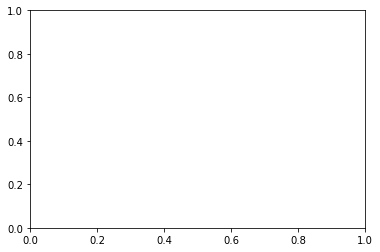

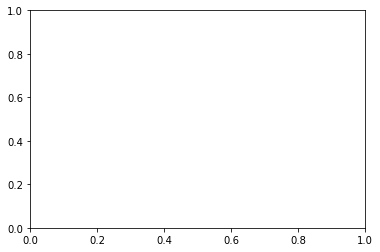

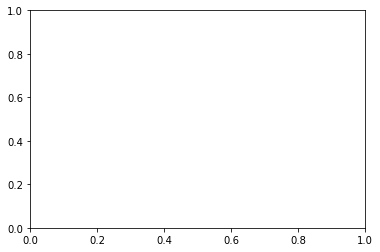

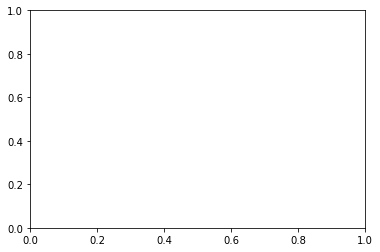

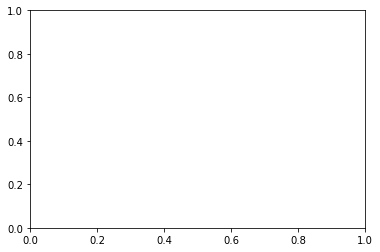

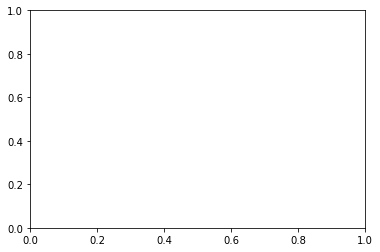

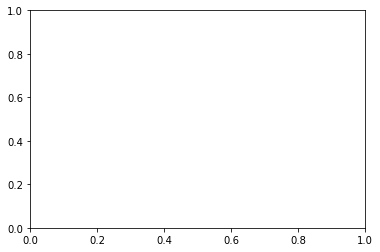

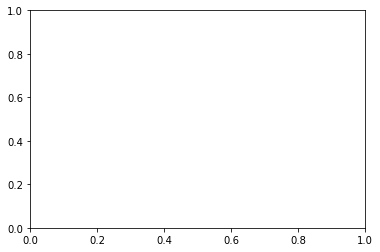

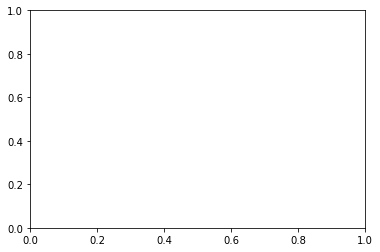

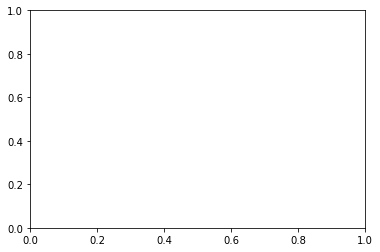

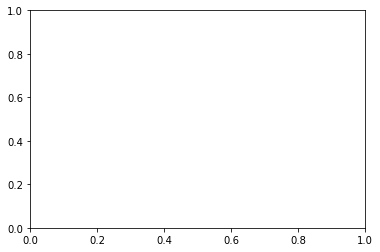

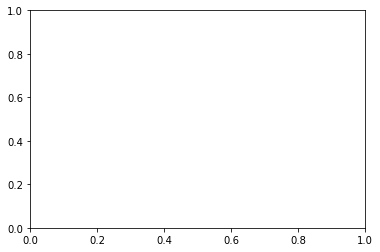

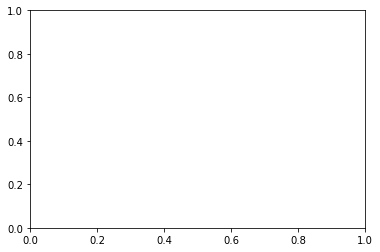

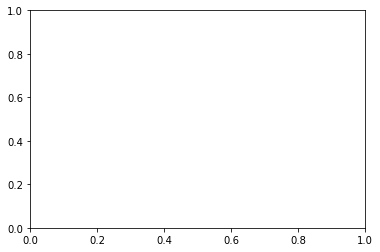

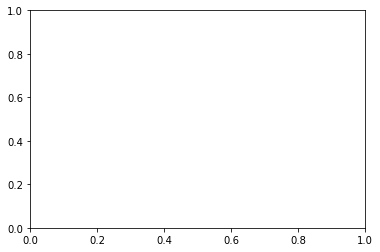

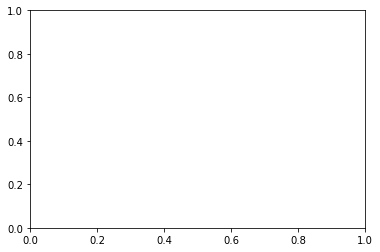

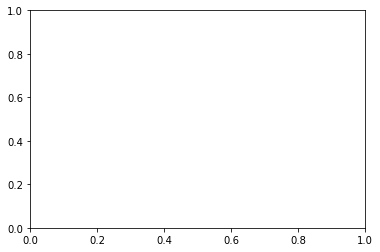

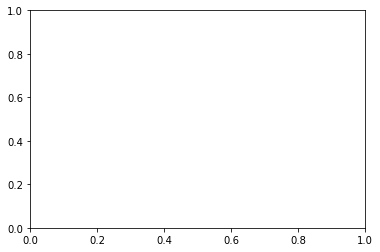

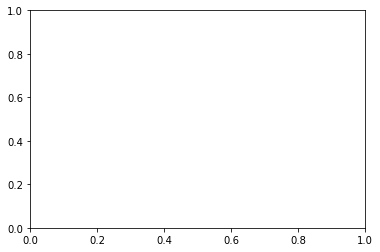

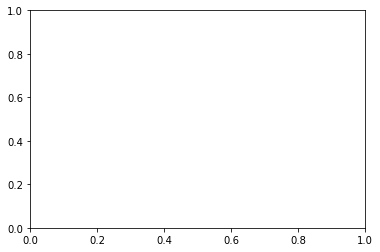

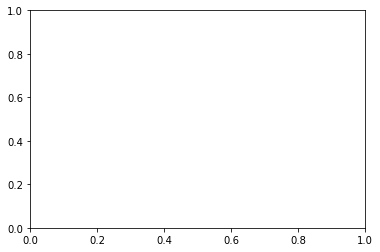

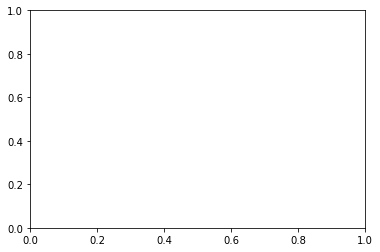

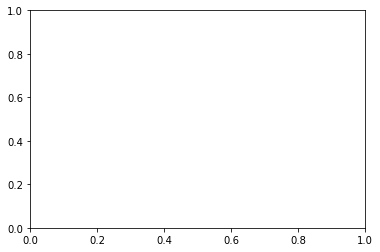

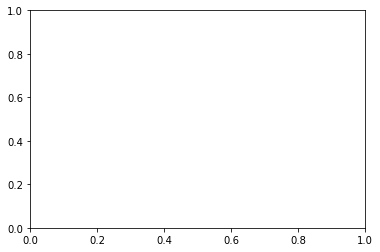

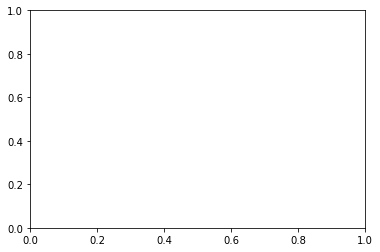

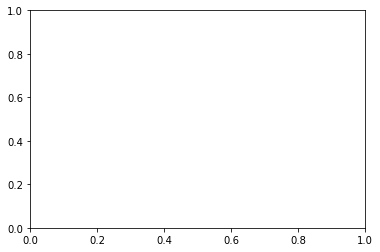

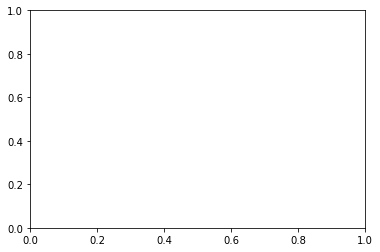

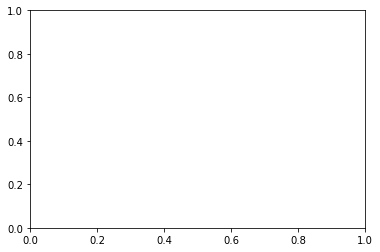

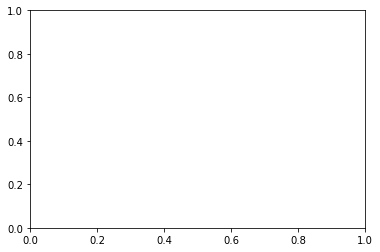

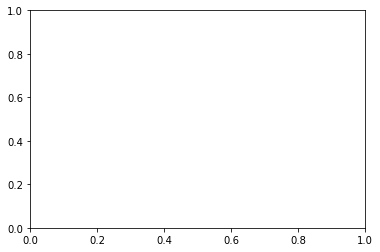

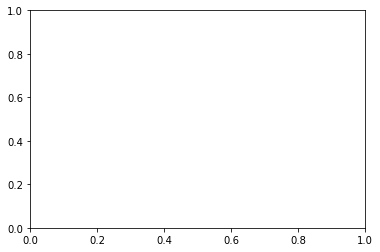

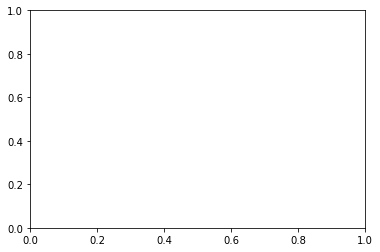

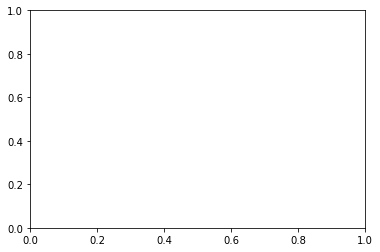

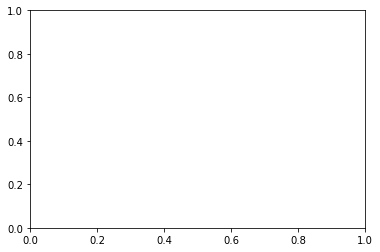

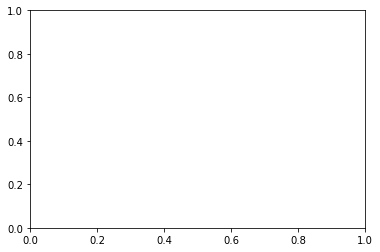

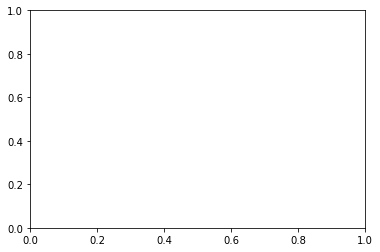

In [17]:
excludelist=[3]
np.random.seed(seed)
colnames=['avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN','pixelVariance','HC intensity ratio']
colnamesloggrad=['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN','pixelVariance','HC intensity ratio']

allcolors=sns.color_palette("tab20",len(plotclusters))
valgradthresh=4

def plotLoss_gradPlots(ctnp,name,plotsavepath,savenameAdd=''):
    if not os.path.exists(plotsavepath):
        os.mkdir(plotsavepath)
#     for x in range(len(colnames)-1):
    for x in range(1):
        if x in excludelist:
            continue
#         for y in range(len(colnames)-1,len(colnames)):
        for y in range(14,15):
            if y in excludelist:
                continue
            fig, ax = plt.subplots()
            res0=np.array([])
            res1=np.array([])
            for ct in range(len(plotclusters)):
                cidx=gaeclusterlabels[sampleNames==s]==plotclusters[ct]
                cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
                allCTnp=celltype_broad[sampleNames==s][cidx]
                curridx=allCTnp==c

                if np.sum(curridx)==0:
                    continue
                if x==0:
                    plotx=np.log(res[s][plotclusters[ct]][curridx,x]+0.5)
                    plotidx=plotx>valgradthresh
                    plotx=plotx[plotidx]
                    ploty=res[s][plotclusters[ct]][curridx,y][plotidx]
#                     ax.scatter(plotx,ploty,color=allcolors[ct],s=1,label=clusterplotname[plotclusters[ct]])
                    res0=np.concatenate((res0,plotx))
                    res1=np.concatenate((res1,ploty))
                else:
                    ax.scatter(res[s][c][curridx,x],res[s][c][curridx,y],color=allcolors[ct],s=1,label=np.unique(celltype_broad)[ct])
            
            regrs=linregress(res0,res1)
            print(regrs.pvalue)
            print(regrs.slope)
#             axes = plt.gca()
#             x_vals = np.array(axes.get_xlim())
#             y_vals = regrs.intercept + regrs.slope * x_vals
#             plt.plot(x_vals, y_vals, '--',color='r')
            
#             ax.legend()
#             ax.set_xlabel(colnamesloggrad[x])
#             if x==0:
#                 ax.set_xlim(valgradthresh,np.log(max(maxvalues['0'][x],maxvalues['1'][x])+0.5))
# #                 ax.set_xlim(np.log(min(minvalues['0'][x],minvalues['1'][x])+0.5),np.log(max(maxvalues['0'][x],maxvalues['1'][x])+0.5))
#             else:
#                 ax.set_xlim(minvalues[c][x],maxvalues[c][x])
#             ax.set_ylim(min(minvalues['0'][y],minvalues['1'][y]),max(maxvalues['0'][y],maxvalues['1'][y]))
#             ax.set_ylabel(colnames[y])
#             ax.grid(False)
#             plt.savefig(os.path.join(plotsavepath,s+colnamesloggrad[x]+'_'+colnames[y]+'_gradthresh.jpg'),dpi=400)
#             plt.close()
        
for s in plot_samples.keys():
#     if 'control' in s:
#         continue
    print(s)
    
    for c in np.unique(celltype_broad):
        
        cidx=celltype_broad[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)<10:
            continue
        print(c)
        if np.sum(cidx)>0:
            allCTnp=gaeclusterlabels[sampleNames==s][cidx]
            plotLoss_gradPlots(allCTnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


In [180]:
#scatter by cell type
excludelist=[3]
np.random.seed(seed)
colnames=['avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN']
colnamesloggrad=['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN']

def plotLoss_gradPlots(ctnp,ctsubnp,name,plotsavepath,savenameAdd=''):
    
#     for x in range(len(colnames)-1):
    for x in range(6,7):
        if x in excludelist:
            continue
#         for y in range(len(colnames)-1,len(colnames)):
        for y in range(7,8):
            if y in excludelist:
                continue
            
            for ct in range(np.unique(celltype_broad).size):
                currBroad=np.unique(celltype_broad)[ct]
                curridx=ctnp==np.unique(celltype_broad)[ct]
                if np.sum(curridx)==0:
                    continue
                currsublist=np.unique(ctsubnp[curridx])
                allcolors=sns.color_palette("tab10",currsublist.size)
                fig, ax = plt.subplots()
                for ctsubidx in range(currsublist.size):
                    ctsubi=currsublist[ctsubidx]
                    curridx_sub=np.logical_and(curridx,(ctsubnp==ctsubi).flatten())
                    if x==0:
                        ax.scatter(np.log(res[s][c][curridx_sub,x]+0.5),res[s][c][curridx_sub,y],color=allcolors[ctsubidx],s=1,label=ctsubi)
                    else:
                        ax.scatter(res[s][c][curridx_sub,x],res[s][c][curridx_sub,y],color=allcolors[ctsubidx],s=1,label=ctsubi)

                ax.legend()
                ax.set_xlabel(colnamesloggrad[x])
#                 if x==0:
#                     ax.set_xlim(np.log(min(minvalues['0'][x],minvalues['1'][x])+0.5),np.log(max(maxvalues['0'][x],maxvalues['1'][x])+0.5))
#                 else:
#                     ax.set_xlim(minvalues[c][x],maxvalues[c][x])
#                 ax.set_ylim(min(minvalues['0'][y],minvalues['1'][y]),max(maxvalues['0'][y],maxvalues['1'][y]))
                ax.set_ylabel(colnames[y])
                plt.savefig(os.path.join(plotsavepath,s+colnamesloggrad[x]+'_'+colnames[y]+currBroad+'.jpg'),dpi=400)
                plt.close()
        
for s in plot_samples.keys():
    if 'control' in s:
        continue
    print(s)
    
    for c in plotclusters:
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            allCTsubnp=celltype_sub[sampleNames==s][cidx]
            plotLoss_gradPlots(allCTnp,allCTsubnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
1
3
disease8
0
1
3


In [296]:
#mean intensity vs volume, colored by avg dist to 3 nn
np.random.seed(seed)
colnames=['avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN']
colnamesloggrad=['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN']
x=6
y=7
coloridx=12
def plotLoss_gradPlots(ctnp,ctsubnp,name,plotsavepath,savenameAdd=''):
    
    for ct in range(np.unique(allCTnp).size):
        currBroad=np.unique(allCTnp)[ct]
        curridx=ctnp==np.unique(allCTnp)[ct]
        if np.sum(curridx)==0:
            continue
        fig, ax = plt.subplots()
        if x==0:
            sc=ax.scatter(np.log(res[s][c][curridx,x]+0.5),res[s][c][curridx,y],c=np.log(res[s][c][curridx,coloridx]+0.5),cmap='coolwarm',s=1)
        else:
            sc=ax.scatter(res[s][c][curridx,x],res[s][c][curridx,y],c=np.log(res[s][c][curridx,coloridx]+0.5),cmap='coolwarm',s=1)

        ax.set_xlabel(colnamesloggrad[x])
#                 if x==0:
#                     ax.set_xlim(np.log(min(minvalues['0'][x],minvalues['1'][x])+0.5),np.log(max(maxvalues['0'][x],maxvalues['1'][x])+0.5))
#                 else:
#                     ax.set_xlim(minvalues[c][x],maxvalues[c][x])
#                 ax.set_ylim(min(minvalues['0'][y],minvalues['1'][y]),max(maxvalues['0'][y],maxvalues['1'][y]))
        ax.set_ylabel(colnames[y])
        fig.colorbar(sc)
        plt.savefig(os.path.join(plotsavepath,s+colnamesloggrad[x]+'_'+colnames[y]+'_logcolor'+colnames[coloridx]+currBroad+'.jpg'),dpi=400)
        plt.close()
        
for s in plot_samples.keys():
    if 'control' not in s:
        continue
    print(s)
    
    for c in plotclusters:
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            allCTsubnp=celltype_sub[sampleNames==s][cidx]
#             allCTnp=np.repeat('all',allCTnp.size)
            plotLoss_gradPlots(allCTnp,allCTsubnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


control13
0
1
3
control8
0
1
3


In [295]:
#mean intensity vs volume, colored by avg dist to 3 nn -- heatmap
np.random.seed(seed)
colnames=['avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN']
colnamesloggrad=['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN']
x=6
y=7
coloridx=12
ngrid=20
def plotLoss_gradPlots(ctnp,ctsubnp,name,plotsavepath,savenameAdd=''):
    
    for ct in range(np.unique(allCTnp).size):
        currBroad=np.unique(allCTnp)[ct]
        curridx=ctnp==np.unique(allCTnp)[ct]
        if np.sum(curridx)==0:
            continue
        fig, ax = plt.subplots()
        if x==0:
            xvalues=np.log(res[s][c][curridx,x]+0.5)
        else:
            xvalues=res[s][c][curridx,x]
        xvalues=xvalues
        yvalues=res[s][c][curridx,y]
        cvalues=np.log(res[s][c][curridx,coloridx]+0.5)
        heatmap=np.zeros((ngrid,ngrid))
        xstep=(np.max(xvalues)+0.01-np.min(xvalues))/ngrid
        ystep=(np.max(yvalues)+0.01-np.min(yvalues))/ngrid
        for xi in range(ngrid):
            for yi in range(ngrid):
                currminx=xi*xstep
                currmaxx=(xi+1)*xstep
                currminy=yi*ystep
                currmaxy=(yi+1)*ystep
                xrange=np.logical_and(xvalues>=currminx,xvalues<currmaxx)
                yrange=np.logical_and(yvalues>=currminy,yvalues<currmaxy)
                heatmap[xi,yi]=np.mean(cvalues[np.logical_and(xrange,yrange)])
        sc=ax.imshow(heatmap,cmap='coolwarm',origin='lower')
        ax.set_xlabel(colnamesloggrad[x])
        ax.set_ylabel(colnames[y])
        fig.colorbar(sc)
        plt.savefig(os.path.join(plotsavepath,s+colnamesloggrad[x]+'_'+colnames[y]+'_logcolor'+colnames[coloridx]+currBroad+'heatmap_highres.jpg'),dpi=400)
        plt.close()
        
for s in plot_samples.keys():
    if 'control' not in s:
        continue
    print(s)
    
    for c in plotclusters:
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            allCTsubnp=celltype_sub[sampleNames==s][cidx]
#             allCTnp=np.repeat('all',allCTnp.size)
            plotLoss_gradPlots(allCTnp,allCTsubnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


control13
0


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1
3
control8
0
1
3


In [308]:
# piechartcutoffs={'log avg grad':5.5,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster013_seed15

#thresholds after fixed missing modelcnn.eval
piechartcutoffs={'log avg grad':6.2,'dapi':0.2,'log plaque':-50,'mean intensity':0.27, 'area':0.3e6,'avg dist to 20 NN':350,'HC ratio':0.8,'avg dist to 3 NN':100,'HC intensity ratio':0.8} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':6.5,'dapi':0.2,'log plaque':-50} #label 2; cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
#label0 is no label in subtype (hc 0.8) no label is label 2 in subtype (hc 0.5)
# piechartcutoffskeys=['log avg grad','mean intensity','area','avg dist to 20 NN','HC ratio','avg dist to 3 NN']
piechartcutoffskeys=['log avg grad','HC intensity ratio']

xpos=[0,1]
ypos=[0,1]
np.random.seed(seed)
colnamesloggrad=np.array(['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN','pixelVariance','HC intensity ratio'])

allcolors=sns.color_palette("tab20",np.unique(celltype_broad).size)
def plotLoss_gradPlots_pie(ctnp,name,plotsavepath,savenameAdd=''):
    resplot=np.copy(res[s][c])
    resplot[:,0]=np.log(resplot[:,0]+0.5)
    for x in range(len(piechartcutoffskeys)-1):
        xname=piechartcutoffskeys[x]
        print(xname)
        for y in range(x+1,len(piechartcutoffskeys)):
            if 'control' in s and piechartcutoffskeys[y]=='log plaque':
                continue
            yname=piechartcutoffskeys[y]
            print(yname)
            fig, ax = plt.subplots()
#             r0=0
            legends=[]
            existingct=[]
            for xpos_i in xpos:
                print(xname+str(np.where(colnamesloggrad==xname)))
                if xpos_i==0:
                    xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()<piechartcutoffs[xname]
                else:
                    xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()>=piechartcutoffs[xname]
                for ypos_i in ypos:
                    if ypos_i==0:
                        yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()<piechartcutoffs[yname]
                    else:
                        yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()>=piechartcutoffs[yname]
                    print('xpos')
                    print(np.where(colnamesloggrad==xname))
                    cidx=np.logical_and(xposIdx,yposIdx)
                    ctnp_i=ctnp[cidx]
                    r0=0
                    for ct in range(np.unique(celltype_broad).size):
                        curridx=ctnp_i==np.unique(celltype_broad)[ct]
                        if np.sum(curridx)==0:
                            continue
        #                 ax.scatter(res[s][c][curridx,x],res[s][c][curridx,y],color=allcolors[ct],s=1,label=np.unique(celltype_broad)[ct])

                        # first define the ratios
                        r1 = r0+np.sum(curridx)/curridx.size
                        print(r0)
                        print(r1)

                        # define some sizes of the scatter marker
                        sizes = 42000

                        # calculate the points of the first pie marker
                        # these are just the origin (0, 0) + some (cos, sin) points on a circle
                        x1 = np.cos(2 * np.pi * np.linspace(r0, r1,1000))
                        y1 = np.sin(2 * np.pi * np.linspace(r0, r1,1000))
#                         print(x1*x1+y1*y1)
                        xy1 = np.row_stack([[0, 0], np.column_stack([x1, y1])])
#                         xy1=np.row_stack((xy1,[0,0]))
                        s1 = np.sum(cidx)/cidx.size
#                         print(s1**2 * sizes)

                        ax.scatter(xpos_i, ypos_i, marker=xy1, s=s1**2*np.abs(xy1).max()**2 * sizes, facecolor=allcolors[ct],linewidths=0)
                        legends.append(Line2D([0], [0], color=allcolors[ct], lw=4))
                        existingct.append(np.unique(celltype_broad)[ct])
                        r0=r1
            existingct_unique,ectidx=np.unique(existingct,return_index=True)
            ax.legend(np.array(legends)[ectidx],existingct_unique)
            ax.set_xlabel(xname)
            ax.set_ylabel(yname)
            ax.set_xlim(-1,2)
            ax.set_ylim(-1,2)
            plt.savefig(os.path.join(plotsavepath,s+xname+'_'+yname+'piechart_radii_label0.jpg'),dpi=400)
            plt.close()
        
for s in plot_samples.keys():
#     if 'control' in s:
#         continue
    print(s)
    
    for c in plotclusters:
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            plotLoss_gradPlots_pie(allCTnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
log avg grad
HC intensity ratio
log avg grad(array([0]),)
xpos
(array([0]),)
0
0.05807365439093484
0.05807365439093484
0.07648725212464588
0.07648725212464588
0.821529745042493
0.821529745042493
0.9178470254957508
0.9178470254957508
0.9475920679886687
0.9475920679886687
0.9603399433427763
0.9603399433427763
0.9858356940509916
0.9858356940509916
1.0
xpos
(array([0]),)
0
0.15151515151515152
0.15151515151515152
0.4242424242424242
0.4242424242424242
0.5454545454545454
0.5454545454545454
0.6666666666666666
0.6666666666666666
0.8787878787878788
0.8787878787878788
0.9696969696969697
0.9696969696969697
1.0
log avg grad(array([0]),)
xpos
(array([0]),)
0
0.0718232044198895
0.0718232044198895
0.10773480662983426
0.10773480662983426
0.5966850828729282
0.5966850828729282
0.7375690607734807
0.7375690607734807
0.839779005524862
0.839779005524862
0.861878453038674
0.861878453038674
0.9806629834254144
0.9806629834254144
1.0
xpos
(array([0]),)
0
0.024
0.024
0.376
0.376
0.4
0.4
0.416000000000

1
log avg grad
HC intensity ratio
log avg grad(array([0]),)
xpos
(array([0]),)
0
0.053125
0.053125
0.059375
0.059375
0.7531249999999999
0.7531249999999999
0.871875
0.871875
0.9093749999999999
0.9093749999999999
0.9218749999999999
0.9218749999999999
0.9906249999999999
0.9906249999999999
0.9999999999999999
xpos
(array([0]),)
0
0.1111111111111111
0.1111111111111111
0.3
0.3
0.6888888888888889
0.6888888888888889
0.7111111111111111
0.7111111111111111
0.8222222222222222
0.8222222222222222
0.8444444444444444
0.8444444444444444
0.9666666666666667
0.9666666666666667
1.0
log avg grad(array([0]),)
xpos
(array([0]),)
0
0.057971014492753624
0.057971014492753624
0.07660455486542443
0.07660455486542443
0.743271221532091
0.743271221532091
0.8612836438923395
0.8612836438923395
0.9047619047619047
0.9047619047619047
0.9233954451345755
0.9233954451345755
0.9979296066252588
0.9979296066252588
1.0
xpos
(array([0]),)
0
0.10740203193033382
0.10740203193033382
0.2002902757619739
0.2002902757619739
0.60377358490

In [23]:
res[s][c]

array([[ 6.78080857e+02,  3.34095435e+03, -1.14065960e+02, ...,
         1.04676034e+02,  1.10547547e-01,  4.28151735e-01],
       [ 6.78747958e+02,  0.00000000e+00, -1.11763365e+02, ...,
         1.01431256e+02,  1.25859850e-01,  5.25417348e-01],
       [ 7.49994938e+02,  1.12457969e+04, -1.21379904e+02, ...,
         1.01460651e+02,  1.13577104e-01,  4.89045214e-01],
       ...,
       [ 9.84347648e+02,  1.92087148e+04, -5.18147831e+01, ...,
         1.45019033e+02,  1.02486793e-01,  4.83760949e-01],
       [ 5.70413430e+02,  2.54437441e+04, -7.17950305e+01, ...,
         1.61708377e+02,  1.18586443e-01,  5.36413726e-01],
       [ 3.36213404e+02,  1.85036719e+04, -3.03243540e+01, ...,
         1.09302598e+02,  1.25153843e-01,  5.59662725e-01]])

In [27]:
matplotlib.rcdefaults()

In [28]:
## combine all CT for pie charts
# piechartcutoffs={'log avg grad':5.5,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster013_seed15

#thresholds after fixed missing modelcnn.eval
piechartcutoffs={'log avg grad':6.2,'dapi':0.2,'log plaque':-50,'HC intensity ratio':0.8} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01

piechartcutoffskeys=['log avg grad','HC intensity ratio']
xpos=[0,1]
ypos=[0,1]
np.random.seed(seed)
colnamesloggrad=np.array(['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN','pixelVariance','HC intensity ratio'])

allcolors=sns.color_palette("tab20",np.unique(celltype_broad).size)
def plotLoss_gradPlots_pie(ctnp,name,plotsavepath,savenameAdd=''):
    resplot=np.copy(res[s][c])
    resplot[:,0]=np.log(resplot[:,0]+0.5)
    for x in range(len(piechartcutoffskeys)-1):
        xname=piechartcutoffskeys[x]
        for y in range(x+1,len(piechartcutoffskeys)):
            yname=piechartcutoffskeys[y]
            fig, ax = plt.subplots()
#             r0=0
            legends=[]
            existingct=[]
            for xpos_i in xpos:
                print(xname+str(np.where(colnamesloggrad==xname)))
                if xpos_i==0:
                    xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()<piechartcutoffs[xname]
                else:
                    xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()>=piechartcutoffs[xname]
                for ypos_i in ypos:
                    print(yname+str(np.where(colnamesloggrad==yname)))
                    if ypos_i==0:
                        yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()<piechartcutoffs[yname]
                    else:
                        yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()>=piechartcutoffs[yname]
                    cidx=np.logical_and(xposIdx,yposIdx)
                    ctnp_i=ctnp[cidx]
                    r0=0
                    r1=0.9999
                    sizes = 42000

                    # calculate the points of the first pie marker
                    # these are just the origin (0, 0) + some (cos, sin) points on a circle
                    x1 = np.cos(2 * np.pi * np.linspace(r0, r1,1000))
                    y1 = np.sin(2 * np.pi * np.linspace(r0, r1,1000))
#                         print(x1*x1+y1*y1)
                    xy1 = np.row_stack([[0, 0], np.column_stack([x1, y1])])
#                         xy1=np.row_stack((xy1,[0,0]))
                    s1 = np.sum(cidx)/cidx.size
#                         print(s1**2 * sizes)

                    ax.scatter(xpos_i, ypos_i, marker=xy1, s=s1**2*np.abs(xy1).max()**2 * sizes, facecolor='red',linewidths=0)
                    
            existingct_unique,ectidx=np.unique(existingct,return_index=True)
            ax.legend(np.array(legends)[ectidx],existingct_unique)
            ax.set_xlabel(xname)
            ax.set_ylabel(yname)
            ax.set_xlim(-1,2)
            ax.set_ylim(-1,2)
            plt.savefig(os.path.join(plotsavepath,s+xname+'_'+yname+'piechart_noCT.jpg'),dpi=400)
            plt.close()
        
for s in plot_samples.keys():
#     if 'control' in s:
#     if 'disease' in s:
#         continue
    print(s)
    
    for c in np.unique(gaeclusterlabels):
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            plotLoss_gradPlots_pie(allCTnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
1
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
2
3
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
4
5
6
7
8
control13
0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
1
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
2
3
log avg grad(array([0]),)
HC inten

In [60]:
# piechartcutoffs={'log avg grad':5.5,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster013_seed15

#thresholds after fixed missing modelcnn.eval
# piechartcutoffs={'log avg grad':6.7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
piechartcutoffs={'log avg grad':6.5,'dapi':0.2,'log plaque':-50} #label 2; cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01

piechartcutoffskeys=['log avg grad','dapi','log plaque']
xpos=[0,1]
ypos=[0,1]
np.random.seed(seed)
colnamesloggrad=np.array(['log avg grad','pred size','log plaque','dapi','secM'])

allcolors=sns.color_palette("tab20",np.unique(celltype_broad).size)
def plotLoss_gradPlots_pie(ctnp,name,plotsavepath,savenameAdd=''):
    resplot=np.copy(res[s][c])
    resplot[:,0]=np.log(resplot[:,0]+0.5)
    for x in range(len(piechartcutoffskeys)-1):
        xname=piechartcutoffskeys[x]
        for y in range(x+1,len(piechartcutoffskeys)):
            yname=piechartcutoffskeys[y]
            fig, ax = plt.subplots()
#             r0=0
            legends=[]
            existingct=[]
            for xpos_i in xpos:
#                 print(xname+str(np.where(colnamesloggrad==xname)))
                if xpos_i==0:
                    xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()<piechartcutoffs[xname]
                else:
                    xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()>=piechartcutoffs[xname]
                for ypos_i in ypos:
#                     print(yname+str(np.where(colnamesloggrad==yname)))
                    if ypos_i==0:
                        yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()<piechartcutoffs[yname]
                    else:
                        yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()>=piechartcutoffs[yname]
                    cidx=np.logical_and(xposIdx,yposIdx)
                    ctnp_i=ctnp[cidx]
                    r0=0
                    lnames=['TP','TN','FP','FN']
                    for ct in range(4):
                        curridx=ctnp_i==lnames[ct]
                        if np.sum(curridx)==0:
                            continue
        #                 ax.scatter(res[s][c][curridx,x],res[s][c][curridx,y],color=allcolors[ct],s=1,label=np.unique(celltype_broad)[ct])

                        # first define the ratios
                        r1 = r0+np.sum(curridx)/curridx.size
#                         print(r0)
#                         print(r1)

                        # define some sizes of the scatter marker
                        sizes = 42000

                        # calculate the points of the first pie marker
                        # these are just the origin (0, 0) + some (cos, sin) points on a circle
                        x1 = np.cos(2 * np.pi * np.linspace(r0, r1,1000))
                        y1 = np.sin(2 * np.pi * np.linspace(r0, r1,1000))
#                         print(x1*x1+y1*y1)
                        xy1 = np.row_stack([[0, 0], np.column_stack([x1, y1])])
#                         xy1=np.row_stack((xy1,[0,0]))
                        s1 = np.sum(cidx)/cidx.size
#                         print(s1**2 * sizes)

                        ax.scatter(xpos_i, ypos_i, marker=xy1, s=s1**2*np.abs(xy1).max()**2 * sizes, facecolor=allcolors[ct],linewidths=0)
                        legends.append(Line2D([0], [0], color=allcolors[ct], lw=4))
                        existingct.append(lnames[ct])
                        r0=r1
            existingct_unique,ectidx=np.unique(existingct,return_index=True)
            ax.legend(np.array(legends)[ectidx],existingct_unique)
            ax.set_xlabel(xname)
            ax.set_ylabel(yname)
            ax.set_xlim(-1,2)
            ax.set_ylim(-1,2)
            plt.savefig(os.path.join(plotsavepath,s+xname+'_'+yname+'piechart_TF2.jpg'),dpi=400)
            plt.close()
        
for s in plot_samples.keys():
#     if 'control' in s:
#         continue
    print(s)
    
    for c in np.unique(gaeclusterlabels):
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        if np.sum(cidx)>0:
            allCTnp=np.repeat('na',np.sum(cidx))
            posidx=res[s][c][:,5]>0
            negidx=res[s][c][:,5]==0
#             loss_test_all_binary=np.zeros(np.sum(cidx))
#             labels=res[s][c][:,5]
#             pred=res[s][c][:,1]
#             for i in range(np.sum(cidx)):
#                 if labels[i]>0 and pred[i]>lossThreshSize:
#                     loss_test_all_binary[i]=0
#         #         elif pred[0]+labels[0]>0.001: #original
#                 elif pred[i]>lossThreshSize or labels[i]>0:
#                     loss_test_all_binary[i]=1
#                 else:
#                     loss_test_all_binary[i]=0
            predposidx=res[s][c][:,1]>=lossThreshSize
            prednegidx=res[s][c][:,1]<lossThreshSize
            allCTnp[np.logical_and(posidx,predposidx)]='TP'
            allCTnp[np.logical_and(posidx,prednegidx)]='FN'
            allCTnp[np.logical_and(negidx,predposidx)]='FP'
            allCTnp[np.logical_and(negidx,prednegidx)]='TN'
            print(np.sum(negidx))
            print(np.sum(posidx))
#             print(np.sum(loss_test_all_binary[negidx])/np.sum(negidx))
#             print(np.sum(loss_test_all_binary[posidx])/np.sum(posidx))
            plotLoss_gradPlots_pie(allCTnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
837
446
1
408
839
2
1437
420
3
692
485
4
1002
473
5
831
468
6
913
61
7
684
25
8
control13
0
1418
0
1
1190
0
2
1534
0
3
880
0
4
996
0
5
548
0
6
558
0
7
627
0
8
15
0
disease8
0
1093
255
1
957
714
2
429
11
3
800
337
4
605
96
5
529
85
6
667
0
7
679
0
8
control8
0
1644
0
1
694
0
2
844
0
3
1415
0
4
1073
0
5
762
0
6
988
0
7
642
0
8


In [65]:
#pie charts by subtypes
# piechartcutoffs={'log avg grad':5.5,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster013_seed15

#thresholds after fixed missing modelcnn.eval
# piechartcutoffs={'log avg grad':6.7,'dapi':0.2,'log plaque':-50,'mean intensity':0.27, 'area':0.3e6,'avg dist to 20 NN':350,'HC ratio':0.8,'HC intensity ratio':0.8} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':6.2,'dapi':0.2,'log plaque':-50,'mean intensity':0.4, 'area':0.3e6,'avg dist to 20 NN':350,'HC ratio':0.5,'HC intensity ratio':0.5} #label 2; cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':6.5,'dapi':0.2,'log plaque':-50,'mean intensity':0.27, 'area':0.3e6,'avg dist to 20 NN':350,'HC ratio':0.8,'HC intensity ratio':0.5} #label 3 cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':6.7,'dapi':0.2,'log plaque':-50,'mean intensity':0.27, 'area':0.3e6,'avg dist to 20 NN':350,'HC ratio':0.8,'HC intensity ratio':0.85} #label 4 cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
piechartcutoffs={'log avg grad':7,'dapi':0.2,'log plaque':-50,'mean intensity':0.27, 'area':0.3e6,'avg dist to 20 NN':350,'HC ratio':0.8,'HC intensity ratio':0.9} #label 5 cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01

piechartcutoffskeys=['log avg grad','HC intensity ratio']
# xpos=[1,0]
# ypos=[1,0]
xpos=[0,1]
ypos=[0,1]
np.random.seed(seed)
colnamesloggrad=np.array(['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN','pixelVariance','HC intensity ratio'])



def plotLoss_gradPlots_pie_byct(ctnp_all,ctnp_sub_all,name,plotsavepath,savenameAdd=''):
    resplot_all=np.copy(res[s][c])
    resplot_all[:,0]=np.log(resplot_all[:,0]+0.5)
    for ctbroad in range(np.unique(celltype_broad).size):
        currBroad=np.unique(celltype_broad)[ctbroad]
#         if currBroad != 'SMC':
#             continue
        ctbroadIdx=ctnp_all==currBroad
        resplot=resplot_all[ctbroadIdx]
        ctnp=ctnp_sub_all[ctbroadIdx]
#         ctnp=np.repeat('SMC',np.sum(ctbroadIdx))
        allcolors=sns.color_palette("tab10",np.unique(ctnp).size)
        for x in range(1):
#         for x in range(len(piechartcutoffskeys)-1):
            xname=piechartcutoffskeys[x]
#             for y in range(1,2):
            for y in range(x+1,len(piechartcutoffskeys)):
                yname=piechartcutoffskeys[y]
                fig, ax = plt.subplots()
    #             r0=0
                legends=[]
                existingct=[]
                for xpos_i in xpos:
                    print(xname+str(np.where(colnamesloggrad==xname)))
                    if xpos_i==0:
                        xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()<piechartcutoffs[xname]
                    else:
                        xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()>=piechartcutoffs[xname]
                    for ypos_i in ypos:
                        print(yname+str(np.where(colnamesloggrad==yname)))
                        if ypos_i==0:
                            yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()<piechartcutoffs[yname]
                        else:
                            yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()>=piechartcutoffs[yname]
                        cidx=np.logical_and(xposIdx,yposIdx)
                        ctnp_i=ctnp[cidx]
                        r0=0
                        for ct in range(np.unique(ctnp).size):
                            curridx=ctnp_i==np.unique(ctnp)[ct]
#                             if np.unique(ctnp)[ct] != 'Oligo':
#                                 continue
                            if np.sum(curridx)==0:
                                continue
            #                 ax.scatter(res[s][c][curridx,x],res[s][c][curridx,y],color=allcolors[ct],s=1,label=np.unique(celltype_broad)[ct])

                            # first define the ratios
                            r1 = r0+np.sum(curridx)/curridx.size
                            print(r0)
                            print(r1)

                            # define some sizes of the scatter marker
                            sizes = 42000

                            # calculate the points of the first pie marker
                            # these are just the origin (0, 0) + some (cos, sin) points on a circle
                            x1 = np.cos(2 * np.pi * np.linspace(r0, r1,1000))
                            y1 = np.sin(2 * np.pi * np.linspace(r0, r1,1000))
    #                         print(x1*x1+y1*y1)
                            xy1 = np.row_stack([[0, 0], np.column_stack([x1, y1])])
    #                         xy1=np.row_stack((xy1,[0,0]))
                            s1 = np.sum(cidx)/cidx.size
    #                         print(s1**2 * sizes)

                            ax.scatter(xpos_i, ypos_i, marker=xy1, s=s1**2*np.abs(xy1).max()**2 * sizes, facecolor=allcolors[ct],linewidths=0)
                            legends.append(Line2D([0], [0], color=allcolors[ct], lw=4))
                            existingct.append(np.unique(ctnp)[ct])
                            r0=r1
                existingct_unique,ectidx=np.unique(existingct,return_index=True)
                ax.legend(np.array(legends)[ectidx],existingct_unique)
                ax.set_xlabel(xname)
                ax.set_ylabel(yname)
                ax.set_xlim(-1,2)
                ax.set_ylim(-1,2)
                plt.savefig(os.path.join(plotsavepath,s+xname+'_'+yname+'piechart_'+currBroad+'label5.jpg'),dpi=400)
                plt.close()
        
for s in plot_samples.keys():
#     if 'control' in s:
#         continue
    print(s)
    
    for c in np.unique(gaeclusterlabels):
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            allCTsubnp=celltype_sub[sampleNames==s][cidx]
            plotLoss_gradPlots_pie_byct(allCTnp,allCTsubnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.5362318840579711
0.5362318840579711
0.9420289855072465
0.9420289855072465
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.5
0.5
0.8333333333333333
0.8333333333333333
0.9999999999999999
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg gra

log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.7058823529411765
0.7058823529411765
0.8823529411764707
0.8823529411764707
1.0
HC intensity ratio(array([14]),)
0
1.0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.529411764

log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.12244897959183673
0.12244897959183673
0.14285714285714285
0.14285714285714285
0.7857142857142858
0.7857142857142858
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.6153846153846154
0.6153846153846154
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.8571428571428571
0.8571428571428571
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC inten

1
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.6506024096385542
0.6506024096385542
0.9156626506024097
0.9156626506024097
1.0
HC intensity ratio(array([14]),)
0
0.4166666666666667
0.4166666666666667
0.9166666666666667
0.9166666666666667
1.0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.5416666666666666
0.5416666666666666
0.875
0.875
1.0
HC intensity ratio(array([14]),)
0
0.4
0.4
1.0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC

log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.6276595744680851
0.6276595744680851
0.8617021276595744
0.8617021276595744
1.0
HC intensity ratio(array([14]),)
0
0.7
0.7
0.7999999999999999
0.7999999999999999
1.0
log avg grad(a

log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.68
0.68
0.9600000000000001
0.9600000000000001
1.0
HC intensity ratio(array([14]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.65
0.65
0.8
0.8
1.0
HC intensity ratio(array([14]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.1394700139470014
0.1394700139470014
0.34309623430962344
0.34309623430962344
0.36401673640167365
0.36401673640167365
1.0
HC intensity ratio(array([14]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.10526315789473684
0.10526315789473684
0.22807017543859648
0.22807017543859648
0.2631578947368421
0.2631578947368421
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.15942028985507245
0.15942028985507245
0.20289855072463767
0.20289855072463767
0.6231884057971014
0.6231884057971014
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(arr

In [34]:
#pie charts by subtypes -TF
# piechartcutoffs={'log avg grad':5.5,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster013_seed15

#thresholds after fixed missing modelcnn.eval
piechartcutoffs={'log avg grad':6.7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01

piechartcutoffskeys=['log avg grad','dapi','log plaque']
# xpos=[1,0]
# ypos=[1,0]
xpos=[0,1]
ypos=[0,1]
np.random.seed(seed)
colnamesloggrad=np.array(['log avg grad','pred size','log plaque','dapi','secM'])


def plotLoss_gradPlots_pie_byct(ctnp_all,ctnp_sub_all,name,plotsavepath,savenameAdd=''):
    resplot_all=np.copy(res[s][c])
    resplot_all[:,0]=np.log(resplot_all[:,0]+0.5)
    lnames=np.array(['TP','TN','FP','FN'])
    for ctbroad in range(np.unique(celltype_broad).size):
        currBroad=np.unique(celltype_broad)[ctbroad]
#         if currBroad != 'SMC':
#             continue
        ctbroadIdx=ctnp_all==currBroad
        resplot=resplot_all[ctbroadIdx]
        ctnp=ctnp_sub_all[ctbroadIdx]
#         ctnp=np.repeat('SMC',np.sum(ctbroadIdx))
        allcolors=sns.color_palette("tab10",lnames.size)
        for x in range(len(piechartcutoffskeys)-1):
            xname=piechartcutoffskeys[x]
            for y in range(x+1,len(piechartcutoffskeys)):
                yname=piechartcutoffskeys[y]
                fig, ax = plt.subplots()
    #             r0=0
                legends=[]
                existingct=[]
                for xpos_i in xpos:
                    print(xname+str(np.where(colnamesloggrad==xname)))
                    if xpos_i==0:
                        xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()<piechartcutoffs[xname]
                    else:
                        xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()>=piechartcutoffs[xname]
                    for ypos_i in ypos:
                        print(yname+str(np.where(colnamesloggrad==yname)))
                        if ypos_i==0:
                            yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()<piechartcutoffs[yname]
                        else:
                            yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()>=piechartcutoffs[yname]
                        cidx=np.logical_and(xposIdx,yposIdx)
                        ctnp_i=ctnp[cidx]
                        r0=0
                        for ct in range(lnames.size):
                            curridx=ctnp_i==lnames[ct]
                            if np.sum(curridx)==0:
                                continue
            #                 ax.scatter(res[s][c][curridx,x],res[s][c][curridx,y],color=allcolors[ct],s=1,label=np.unique(celltype_broad)[ct])

                            # first define the ratios
                            r1 = r0+np.sum(curridx)/curridx.size
                            print(r0)
                            print(r1)

                            # define some sizes of the scatter marker
                            sizes = 42000

                            # calculate the points of the first pie marker
                            # these are just the origin (0, 0) + some (cos, sin) points on a circle
                            x1 = np.cos(2 * np.pi * np.linspace(r0, r1,1000))
                            y1 = np.sin(2 * np.pi * np.linspace(r0, r1,1000))
    #                         print(x1*x1+y1*y1)
                            xy1 = np.row_stack([[0, 0], np.column_stack([x1, y1])])
    #                         xy1=np.row_stack((xy1,[0,0]))
                            s1 = np.sum(cidx)/cidx.size
    #                         print(s1**2 * sizes)

                            ax.scatter(xpos_i, ypos_i, marker=xy1, s=s1**2*np.abs(xy1).max()**2 * sizes, facecolor=allcolors[ct],linewidths=0)
                            legends.append(Line2D([0], [0], color=allcolors[ct], lw=4))
                            existingct.append(lnames[ct])
                            r0=r1
                existingct_unique,ectidx=np.unique(existingct,return_index=True)
                ax.legend(np.array(legends)[ectidx],existingct_unique)
                ax.set_xlabel(xname)
                ax.set_ylabel(yname)
                ax.set_xlim(-1,2)
                ax.set_ylim(-1,2)
                plt.savefig(os.path.join(plotsavepath,s+xname+'_'+yname+'piechart_'+currBroad+'_TF.jpg'),dpi=400)
                plt.close()
        
for s in plot_samples.keys():
#     if 'disease' in s:
#         continue
    print(s)
    
    for c in np.unique(gaeclusterlabels):
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
#             allCTsubnp=celltype_sub[sampleNames==s][cidx]
            allCTsubnp=np.repeat('na',np.sum(cidx))
            posidx=res[s][c][:,5]>0
            negidx=res[s][c][:,5]==0
            predposidx=res[s][c][:,1]>=lossThreshSize
            prednegidx=res[s][c][:,1]<lossThreshSize
            allCTsubnp[np.logical_and(posidx,predposidx)]='TP'
            allCTsubnp[np.logical_and(posidx,prednegidx)]='FN'
            allCTsubnp[np.logical_and(negidx,predposidx)]='FP'
            allCTsubnp[np.logical_and(negidx,prednegidx)]='TN'
            plotLoss_gradPlots_pie_byct(allCTnp,allCTsubnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.21212121212121213
0.21212121212121213
0.6666666666666666
0.6666666666666666
1.0
dapi(array([3]),)
0
0.18181818181818182
0.18181818181818182
0.8181818181818181
0.8181818181818181
0.9393939393939393
0.9393939393939393
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
0.45454545454545453
0.45454545454545453
0.5454545454545454
0.5454545454545454
0.9090909090909091
0.9090909090909091
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.6818181818181818
0.6818181818181818
1.0
log plaque(array([2]),)
0
0.5909090909090909
0.5909090909090909
0.8636363636363636
0.8636363636363636
0.9090909090909091
0.9090909090909091
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.25
0.25
1.0
log plaque(array([2]),)
0
0.75
0.75
0.875
0.875
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.5833333333333334
0.5833333333333334
1.0
log plaque(array([2]),)
0
0.8
0.8
0.9
0.9
1.0
dapi(array([3]),)
log plaque(array([2]),)


log avg grad(array([0]),)
dapi(array([3]),)
0
0.3333333333333333
0.3333333333333333
0.5555555555555556
0.5555555555555556
0.8888888888888888
0.8888888888888888
1.0
dapi(array([3]),)
0
0.3333333333333333
0.3333333333333333
0.6666666666666666
0.6666666666666666
0.8333333333333333
0.8333333333333333
0.9999999999999999
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.3333333333333333
0.3333333333333333
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.5714285714285714
0.5714285714285714
1.0
log plaque(array([2]),)
0
0.625
0.625
0.75
0.75
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.4
0.4
1.0
log plaque(array([2]),)
0
0.75
0.75
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.6666666666666666
0.6666666666666666
1.0
log plaque(array([2]),)
0
0.3333333333333333
0.3333333333333333
0.5
0.5
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.36363636363636365
0.36363636363636365
0

dapi(array([3]),)
log plaque(array([2]),)
0
0.18181818181818182
0.18181818181818182
1.0
log plaque(array([2]),)
0
0.6093189964157706
0.6093189964157706
0.6810035842293907
0.6810035842293907
0.8243727598566308
0.8243727598566308
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.21739130434782608
0.21739130434782608
1.0
log plaque(array([2]),)
0
0.5748031496062992
0.5748031496062992
0.6377952755905512
0.6377952755905512
0.7480314960629921
0.7480314960629921
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.5409836065573771
0.5409836065573771
0.6557377049180328
0.6557377049180328
0.9016393442622952
0.9016393442622952
1.0
dapi(array([3]),)
0
0.2
0.2
0.4
0.4
0.8
0.8
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.8
0.8
1.0
dapi(array([3]),)
0
0.6
0.6
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.35294117647058826
0.35294117647058826
1.0
log plaque(array([2]),)
0
0.6938775510204082
0.6938775510204082
0.7346938775510204
0.7346938775510204
0.8571428571428572
0.857142857142857

dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
0.20270270270270271
0.20270270270270271
0.5
0.5
0.8716216216216216
0.8716216216216216
1.0
dapi(array([3]),)
0
0.07648183556405354
0.07648183556405354
0.5248565965583174
0.5248565965583174
0.8795411089866156
0.8795411089866156
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.1574642126789366
0.1574642126789366
0.39877300613496935
0.39877300613496935
0.9386503067484663
0.9

log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log pl

log avg grad(array([0]),)
log plaque(array([2]),)
0
0.2857142857142857
0.2857142857142857
1.0
log plaque(array([2]),)
0
0.5
0.5
0.5652173913043478
0.5652173913043478
0.9130434782608695
0.9130434782608695
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.16666666666666666
0.16666666666666666
0.986111111111111
0.986111111111111
0.9999999999999999
log plaque(array([2]),)
0
0.6067415730337079
0.6067415730337079
0.6853932584269663
0.6853932584269663
0.9662921348314607
0.9662921348314607
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.24
0.24
1.0
log plaque(array([2]),)
0
0.5333333333333333
0.5333333333333333
0.6
0.6
0.9333333333333333
0.9333333333333333
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.19718309859154928
0.19718309859154928
0.9859154929577464
0.9859154929577464
0.9999999999999999
log plaque(array([2]),)
0
0.5888888888888889
0.5888888888888889
0.6666666666666667
0.6666666666666667
0.9555555555555556
0.9555555555555556
1.0
log avg grad(array([0]),)
dapi(array([3]),)


log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
0.75
0.75
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
0.75
0.75
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.5909090909090909
0.5909090909090909
0.6060606060606061
0.6060606060606061
0.9090909090909092
0.9090909090909092
1.0
dapi(array([3]),)
0
0.25925925925925924
0.25925925925925924
0.3333333333333333
0.3333333333333333
0.8888888888888888
0.8888888888888888
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.6
0.6
0.7
0.7
1.0
dapi(array([3]),)
0
0.5029585798816568
0.5029585798816568
0.5207100591715976
0.5207100591715976
0.9822485207100592
0.9822485207100592
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.08
0.08
1.0
log plaque(array([2]),)
0
0.6764705882352942
0.6764705882352942
0.6911764705882353
0.69117

0.4666666666666667
0.9666666666666667
0.9666666666666667
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.125
0.125
1.0
log plaque(array([2]),)
0
0.8333333333333334
0.8333333333333334
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
0.7142857142857143
0.7142857142857143
0.9523809523809523
0.9523809523809523
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.1111111111111111
0.1111111111111111
1.0
log plaque(array([2]),)
0
0.75
0.75
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
0.7368421052631579
0.7368421052631579
0.9473684210526315
0.9473684210526315
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
dapi(

log avg grad(array([0]),)
dapi(array([3]),)
0
0.6923076923076923
0.6923076923076923
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.7692307692307693
0.7692307692307693
1.0
log plaque(array([2]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
0.7272727272727273
0.7272727272727273
1.0
log plaque(array([2]),)
0
0.5
0.5
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.6666666666666666
0.6666666666666666
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
0.8888888888888888
0.8888888888888888
1.0
dapi(array([3]),)
0
0.75
0.75
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
0.6
0.6
0.8
0.8
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]

log avg grad(array([0]),)
dapi(array([3]),)
0
0.00273224043715847
0.00273224043715847
0.8770491803278688
0.8770491803278688
0.9672131147540983
0.9672131147540983
1.0
dapi(array([3]),)
0
0.9029126213592233
0.9029126213592233
0.9514563106796117
0.9514563106796117
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.9153318077803204
0.9153318077803204
1.0
log plaque(array([2]),)
0
0.03125
0.03125
0.4375
0.4375
0.46875
0.46875
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.9058823529411765
0.9058823529411765
1.0
log plaque(array([2]),)
0
0.038461538461538464
0.038461538461538464
0.5
0.5
0.5384615384615384
0.5384615384615384
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.9484536082474226
0.9484536082474226
1.0
log plaque(array([2]),)
0
0.14285714285714285
0.14285714285714285
0.2857142857142857
0.2857142857142857
1.0
log avg grad(array

dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
0.8571428571428571
0.8571428571428571
1.0
dapi(array([3]),)
0
0.9
0.9
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.8764044943820225
0.8764044943820225
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.8571428571428571
0.8571428571428571
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.8809523809523809
0.8809523809523809
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.9135483870967742
0.9135483870967742
1.0
dapi(array([3]),)
0
0.9379310344827586
0.9379310344827586
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]

log avg grad(array([0]),)
dapi(array([3]),)
0
0.7837837837837838
0.7837837837837838
1.0
dapi(array([3]),)
0
0.8484848484848485
0.8484848484848485
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.8037383177570093
0.8037383177570093
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.7837837837837838
0.7837837837837838
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.8235294117647058
0.8235294117647058
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
0.5555555555555556
0.5555555555555556
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),

dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.4
0.4
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]

log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.6846153846153846
0.6846153846153846
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.16666666666666666
0.16666666666666666
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5211267605633803
0.5211267605633803
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5210084033613446
0.5210084033613446
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.6666666666666666
0.6666666666666666
1.0
4
log avg grad(array([0]),)
dapi(array([3]),)
0
0.17105263

log avg grad(array([0]),)
dapi(array([3]),)
0
0.15384615384615385
0.15384615384615385
1.0
dapi(array([3]),)
0
0.30434782608695654
0.30434782608695654
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.0945945945945946
0.0945945945945946
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.25
0.25
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.0945945945945946
0.0945945945945946
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.15384615384615385
0.15384615384615385
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.14432989690721648
0.14432989690721648
1.0
5
log avg grad(array([0]),)
dapi(array([3]),)
0
0.2
0.2
1.0
dapi(array([3]),)
0
0.38461538461538464
0.38461538461538464
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
0.05
0.05
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.2727272727272727
0.272

log avg grad(array([0]),)
dapi(array([3]),)
0
0.937799043062201
0.937799043062201
1.0
dapi(array([3]),)
0
0.939622641509434
0.939622641509434
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.9388185654008439
0.9388185654008439
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.937799043062201
0.937799043062201
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.9363295880149812
0.9363295880149812
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),

log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
0.9047619047619048
0.9047619047619048
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.9130434782608695
0.913

log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
disease8
0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.20833333333333334
0.20833333333333334
0.45833333333333337
0.45833333333333337
0.9583333333333334


log avg grad(array([0]),)
log plaque(array([2]),)
0
0.5666666666666667
0.5666666666666667
1.0
log plaque(array([2]),)
0
0.25
0.25
0.40625
0.40625
0.59375
0.59375
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.42857142857142855
0.42857142857142855
1.0
log plaque(array([2]),)
0
0.5652173913043478
0.5652173913043478
0.6521739130434783
0.6521739130434783
0.8695652173913043
0.8695652173913043
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
log plaque(array([2]),)
0
0.3333333333333333
0.3333333333333333
0.41666666666666663
0.41666666666666663
0.6666666666666666
0.6666666666666666
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.5555555555555556
0.5555555555555556
1.0
log plaque(array([2]),)
0
0.3953488372093023
0.3953488372093023
0.5348837209302325
0.5348837209302325
0.7209302325581395
0.7209302325581395
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.6666666666666666
0.6666666666666666
1.0
dapi(array([3]),)
0
0.625
0.625
1.0
log avg grad(array([0]),)
dapi(array([

log avg grad(array([0]),)
log plaque(array([2]),)
0
0.47593582887700536
0.47593582887700536
1.0
log plaque(array([2]),)
0
0.2891246684350133
0.2891246684350133
0.49867374005305043
0.49867374005305043
0.7029177718832892
0.7029177718832892
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.24615384615384617
0.24615384615384617
1.0
log plaque(array([2]),)
0
0.4880382775119617
0.4880382775119617
0.5933014354066986
0.5933014354066986
0.7894736842105263
0.7894736842105263
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.40625
0.40625
1.0
log plaque(array([2]),)
0
0.34185303514376997
0.34185303514376997
0.5175718849840256
0.5175718849840256
0.744408945686901
0.744408945686901
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.35668789808917195
0.35668789808917195
1.0
log plaque(array([2]),)
0
0.38095238095238093
0.38095238095238093
0.5494505494505495
0.5494505494505495
0.7216117216117217
0.7216117216117217
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.14102564102564102
0.14102564

log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
0.4
0.4
1.0
dapi(array([3]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
lo

dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),

log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.3
0.3
0.8
0.8
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
0.6
0.6
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
0.6
0.6
1.0
4
log avg grad(array([0]),)
dapi(array([3]),)
0
0.14285714285714285
0.14285714285714285
0.5357142857142857
0.5357142857142857
1.0
dapi(array([3]),)
0
0.11864406779661017
0.11864406779661017
0.559322033898305
0.559322033898305
0.9491525423728813
0.9491525423728813
0.9999999999999999
log avg grad(array([0]),)
dapi(array([3]),)
0
0.2
0.2
1.0
dapi(array([3]),)
0
0.13513513513513514
0.13513513513513514
0.17117117117117117
0.17117117117117117
0.990990990990991
0.990990990990991
1.0
log avg grad(array([0

log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
0.6
0.6
0.8
0.8
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.058823529411764705
0.058823529411764705
0.11764705882352941
0.11764705882352941
0.9411764705882353
0.9411764705882353
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.5555555555555556
0.5555555555555556
1.0
log plaque(array([2]),)
0
0.3333333333333333
0.3333333333333333
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.07692307692307693
0.07692307692307693
1.0
log plaque(array([2]),)
0
0.25
0.25
0.75
0.75
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
0.3
0.3
1.0
log plaque(array([2]),)
0
0.14285714285714285
0.14285714285714285
0.2857142857142857
0.2857142857142857
0.5714285714285714
0.5714285714285714
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.125
0.125
0.5
0.5
1.0
dapi(array([3]),)
0
0.07692307692307693
0.07692307692307693
0.69230769

log avg grad(array([0]),)
log plaque(array([2]),)
0
0.25
0.25
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
0.42857142857142855
0.42857142857142855
0.5714285714285714
0.5714285714285714
0.8571428571428571
0.8571428571428571
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.1111111111111111
0.1111111111111111
1.0
log plaque(array([2]),)
0
0.5
0.5
0.6666666666666666
0.6666666666666666
0.8333333333333333
0.8333333333333333
0.9999999999999999
log avg grad(array([0]),)
dapi(array([3]),)
0
0.14754098360655737
0.14754098360655737
0.22950819672131145
0.22950819672131145
1.0
dapi(array([3]),)
0
0.4
0.4
0.9500000000000001
0.9500000000000001
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.09090909090909091
0.09090909090909091
0.22727272727272727
0.22727272727272727
1.0
dapi(array([3]),)
0
0.12349397590361445
0.12349397590361445
0.1897590361445783
0.1897

dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
0.3333333333333333
0.3333333333333333
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.25
0.25
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
0.3333333333333333
0.3333333333333333
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)


dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.4807692307692308
0.4807692307692308
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.4225352112676056
0.4225352112676056
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
da

log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaq

log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
0.14285714285714285
0.14285714285714285
1.0
dapi(array([3]),)
0
0.222222222222

dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
0.5555555555555556
0.5555555555555556
1.0
dapi(array([3]),)
0
0.6363636363636364
0.6363636363636364
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
0.13333333333333333
0.13333333333333333
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.6
0.6
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.125
0.125
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.34615384615384615
0.34615384615384615
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.16666666666666666
0.16666666666666666
1.0
dapi(array([3]),)
0
0.5714285714285714
0.5714285714285714
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad

log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.3142857142857143
0.3142857142857143
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.06172839506172839
0.06172839506172839
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.10526315789473684
0.10526315789473684
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.14432989690721648
0.14432989690721648
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.14285714285714285
0.14285714285714285
1.0
dapi(array([3]),)
0
0.5882352941176471
0.5882352941176471
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
0.12
0.12
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.3870967741935484
0.3870967741935484
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.1111111111111111
0.1111111111111111
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)


log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
6
log avg grad(array([0]),)
dapi(array([3]),)
0
0.5
0.5
1.0
dapi(array([3]),)
0
0.6363636363636364
0.6363636363636364
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.6071428571428571
0.6071428571428571
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.6363636363636364
0.636363636

log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.9114391143911439
0.9114391143911439
1.0
dapi(array([3]),)
0
0.9318181818181818
0.9318181818181818
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.9181141439205955
0.9181141439205955
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.9117647058823529
0.9117647058823529
1.0
dapi(array([3]),)
log plaque(array([2]),